In [1]:
!pip install xarray zarr dask lightning matplotlib wandb cftime einops --quiet

import os
from datetime import datetime
import numpy as np
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl

In [2]:
ls

 Volume in drive C is OS
 Volume Serial Number is 1AD0-BCE1

 Directory of C:\Users\20187\CSE 151B\Project

05/16/2025  07:05 PM    <DIR>          .
05/15/2025  07:46 PM    <DIR>          ..
05/16/2025  06:39 PM    <DIR>          .ipynb_checkpoints
05/14/2025  03:26 AM           326,605 1.2.2 Plot.png
05/14/2025  04:25 AM         1,143,745 1.EC.png
05/16/2025  06:37 PM    <DIR>          checkpoints
05/15/2025  10:46 PM            19,827 CNN 90 Epoch.png
05/16/2025  06:06 PM           258,257 CNN Baseline.ipynb
05/13/2025  06:59 PM            73,136 CSE151B_2025_Milestone.pdf
05/16/2025  06:50 PM           204,507 Epoch Test.ipynb
05/16/2025  06:44 PM    <DIR>          lightning_logs
05/16/2025  07:05 PM            50,248 MLP.ipynb
05/16/2025  06:37 PM    <DIR>          Model CKPT
05/15/2025  05:06 AM           117,389 Performance 10 Epochs.png
05/15/2025  05:02 AM           118,348 Performance 30 Epochs.png
05/13/2025  07:24 PM    <DIR>          processed_data_cse151b_v2_corrupted_ssp2

In [3]:
#NOTE Change the data directory according to where you have your zarr files stored
config = {
    "data": {
        "path": "processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        # "path": "/Users/charles/Downloads/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 64,
        "num_workers": 0,
    },
    "model": {
        "type": "mlp",
        "input_dim": 64,                      # will override n_input_channels if provided
        "hidden_dims": [128, 128, 128, 128],  # replace hidden_dim + depth
        "dropout": 0.1,                       # matches the __init__ arg name
        "activation": "relu",                 # you can still read this if you wire it up
    },
    "training": {
        "lr": 1e-3,
    },
    "trainer": {
        "max_epochs": 1000,
        "accelerator": "auto",
        "devices": "auto",
        "precision": 32,
        "deterministic": True,
        "num_sanity_val_steps": 0,
    },
    "seed": 42,
}
pl.seed_everything(config["seed"])  # Set seed for reproducibility

Seed set to 42


42

In [4]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock1D(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, out_dim)
        self.bn1 = nn.BatchNorm1d(out_dim)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(out_dim, out_dim)
        self.bn2 = nn.BatchNorm1d(out_dim)

        # if dims mismatch, project the shortcut
        self.shortcut = (
            nn.Linear(in_dim, out_dim)
            if in_dim != out_dim
            else nn.Identity()
        )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.fc1(x)))
        out = self.bn2(self.fc2(out))
        out += identity
        return self.relu(out)

class MLP(nn.Module):
    def __init__(
        self,
        n_input_channels: int,
        n_output_channels: int,
        input_dim: int = None,                      # total flattened inputs = C_in * H * W
        hidden_dims: list[int] = [128, 128, 128, 128],
        dropout: float = 0.1,
        activation: str = "relu",
        spatial_shape: tuple[int,int] = None,       # (H, W)
    ):
        super().__init__()

        # figure out how many features we’re flattening
        # if input_dim not given, assume no spatial flattening (rare for climate)
        in_features = input_dim if input_dim is not None else n_input_channels

        # keep spatial dims for the final reshape
        self.spatial_shape     = spatial_shape
        self.n_output_channels = n_output_channels

        self.flatten = nn.Flatten()

        # build the hidden‐layer stack
        dims = [in_features] + hidden_dims
        self.layers = nn.ModuleList(
            nn.Linear(d_in, d_out) 
            for d_in, d_out in zip(dims[:-1], dims[1:])
        )

        # final projection: to either C_out (scalar) or full map size
        if spatial_shape is None:
            out_features = n_output_channels
        else:
            H, W = spatial_shape
            out_features = n_output_channels * H * W

        self.output = nn.Linear(hidden_dims[-1], out_features)
        self.dropout = nn.Dropout(dropout)

        # module‐based activation
        act = activation.lower()
        if act == "relu":
            self.activation = nn.ReLU(inplace=True)
        elif act == "tanh":
            self.activation = nn.Tanh()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

    def forward(self, x):
        x = self.flatten(x)                    # [B, in_features]
        for layer in self.layers:
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x)

        x = self.output(x)                     # [B, out_features]
        if self.spatial_shape is not None:
            B = x.shape[0]
            H, W = self.spatial_shape
            # reshape to [B, C_out, H, W]
            x = x.view(B, self.n_output_channels, H, W)
        return x


In [6]:
class Normalizer:
    def __init__(self):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        return data * self.std_out + self.mean_out


In [7]:
class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        # val_split=0.1,
        test_months=360,
        batch_size=32,
        num_workers=0,
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        # self.val_split = val_split
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.normalizer = Normalizer()

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp):
            input_dask, output_dask = [], []
            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp)
                if "latitude" in da_var.dims:
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.target_member_id)
                if set(da_var.dims) == {"time"}:
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask.append(da_var.data)

            for var in self.output_vars:
                da_out = ds[var].sel(ssp=ssp, member_id=self.target_member_id)
                if "latitude" in da_out.dims:
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask.append(da_out.data)

            return da.stack(input_dask, axis=1), da.stack(output_dask, axis=1)

        train_input, train_output, val_input, val_output = [], [], None, None

        for ssp in self.train_ssps:
            x, y = load_ssp(ssp)
            if ssp == "ssp370":
                val_input = x[-self.test_months:]
                val_output = y[-self.test_months:]
                train_input.append(x[:-self.test_months])
                train_output.append(y[:-self.test_months])
            else:
                train_input.append(x)
                train_output.append(y)

        train_input = da.concatenate(train_input, axis=0)
        train_output = da.concatenate(train_output, axis=0)

        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output, axis=(0, 2, 3), keepdims=True).compute(),
        )

        train_input_norm = self.normalizer.normalize(train_input, "input")
        train_output_norm = self.normalizer.normalize(train_output, "output")
        val_input_norm = self.normalizer.normalize(val_input, "input")
        val_output_norm = self.normalizer.normalize(val_output, "output")

        test_input, test_output = load_ssp(self.test_ssp)
        test_input = test_input[-self.test_months:]
        test_output = test_output[-self.test_months:]
        test_input_norm = self.normalizer.normalize(test_input, "input")

        self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
        self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        self.test_dataset = ClimateDataset(test_input_norm, test_output, output_is_normalized=False)

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon

In [8]:
import pandas as pd

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model']) # Save all hyperparameters except the model to self.hparams.<param_name>
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer  # Get the normalizer from the datamodule (see above)

    def training_step(self, batch, batch_idx):
        x, y = batch # Unpack inputs and targets (this is the output of the _getitem_ method in the Dataset above)
        y_hat = self(x)   # Forward pass
        loss = self.criterion(y_hat, y)  # Calculate loss
        self.log("train/loss", loss)  # Log loss for tracking
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss)

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)

        return loss

    def on_validation_epoch_end(self):
        # Concatenate all predictions and ground truths from each val step/batch into one array
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        # Concatenate all predictions and ground truths from each test step/batch into one array
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            # RMSE
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            # RMSE of time-mean
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            # MAE of time-stddev
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")
        

In [12]:
# Save the best model

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import Trainer

# Define checkpoint callback to monitor val_loss (you can change to any metric you log, e.g., 'val/tas_rmse')
best_ckpt_callback = ModelCheckpoint(
    dirpath="checkpoints/",
    filename="best-{epoch:02d}-{val/tas/rmse:.4f}",
    monitor="val/tas/rmse",   # <-- make sure you are logging this metric during validation
    save_top_k=1,
    mode="min",  # 'min' because lower loss is better; use 'max' if higher metric is better
)

In [25]:
# config["data"]["batch_size"] = 32
# config["training"]["lr"] = 8e-4

config["model"]["dropout"] = 0.05
config["trainer"]["precision"] = 64
config["trainer"]["max_epochs"] = 500

In [26]:
datamodule = ClimateDataModule(**config["data"])
datamodule.setup()  # so .lat and .lon are populated

# compute true flattened dims
C_in = len(config["data"]["input_vars"])
H    = len(datamodule.lat)
W    = len(datamodule.lon)
flat_in = C_in * H * W

model = MLP(
    n_input_channels   = C_in,
    n_output_channels  = len(config["data"]["output_vars"]),
    input_dim          = flat_in,                  # now matches flattened input
    hidden_dims        = config["model"]["hidden_dims"],
    dropout            = config["model"]["dropout"],
    activation         = config["model"]["activation"],
    spatial_shape      = (H, W),                   # so final map has correct H×W
)

lightning_module = ClimateEmulationModule(
    model,
    learning_rate = config["training"]["lr"]
)

trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)

Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | MLP     | 3.2 M  | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.613    Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
C:\Users\20187\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
C:\Users\20187\anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=4.8357, Time-Mean RMSE=2.4710, Time-Stddev MAE=1.5886
[VAL] pr: RMSE=2.6943, Time-Mean RMSE=0.5256, Time-Stddev MAE=1.5270


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=3.9806, Time-Mean RMSE=2.3362, Time-Stddev MAE=1.0271
[VAL] pr: RMSE=2.5937, Time-Mean RMSE=0.4180, Time-Stddev MAE=1.4763


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=3.3919, Time-Mean RMSE=1.4982, Time-Stddev MAE=1.0378
[VAL] pr: RMSE=2.5651, Time-Mean RMSE=0.3878, Time-Stddev MAE=1.4629


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=3.5283, Time-Mean RMSE=1.7148, Time-Stddev MAE=1.2005
[VAL] pr: RMSE=2.5552, Time-Mean RMSE=0.3862, Time-Stddev MAE=1.4782


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=3.0397, Time-Mean RMSE=0.6344, Time-Stddev MAE=0.9833
[VAL] pr: RMSE=2.5162, Time-Mean RMSE=0.3121, Time-Stddev MAE=1.3743


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=3.3917, Time-Mean RMSE=0.9171, Time-Stddev MAE=0.8089
[VAL] pr: RMSE=2.5377, Time-Mean RMSE=0.3235, Time-Stddev MAE=1.3477


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.8132, Time-Mean RMSE=1.7093, Time-Stddev MAE=0.5381
[VAL] pr: RMSE=2.3317, Time-Mean RMSE=0.3355, Time-Stddev MAE=1.2356


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.7903, Time-Mean RMSE=1.5436, Time-Stddev MAE=0.5004
[VAL] pr: RMSE=2.2921, Time-Mean RMSE=0.3595, Time-Stddev MAE=1.1037


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.7646, Time-Mean RMSE=0.5738, Time-Stddev MAE=0.9192
[VAL] pr: RMSE=2.2584, Time-Mean RMSE=0.2877, Time-Stddev MAE=1.0767


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.5674, Time-Mean RMSE=1.8076, Time-Stddev MAE=0.5158
[VAL] pr: RMSE=2.1157, Time-Mean RMSE=0.3403, Time-Stddev MAE=1.0136


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.2289, Time-Mean RMSE=1.2854, Time-Stddev MAE=0.5972
[VAL] pr: RMSE=2.0935, Time-Mean RMSE=0.3158, Time-Stddev MAE=1.0044


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.6758, Time-Mean RMSE=1.5186, Time-Stddev MAE=0.7647
[VAL] pr: RMSE=2.1360, Time-Mean RMSE=0.3621, Time-Stddev MAE=0.9803


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.1290, Time-Mean RMSE=1.4349, Time-Stddev MAE=0.3867
[VAL] pr: RMSE=2.0446, Time-Mean RMSE=0.3407, Time-Stddev MAE=0.9135


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.0547, Time-Mean RMSE=1.2482, Time-Stddev MAE=0.4494
[VAL] pr: RMSE=2.0166, Time-Mean RMSE=0.2921, Time-Stddev MAE=0.8774


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.9788, Time-Mean RMSE=1.3332, Time-Stddev MAE=0.4484
[VAL] pr: RMSE=2.0156, Time-Mean RMSE=0.3231, Time-Stddev MAE=0.9272


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.6909, Time-Mean RMSE=2.1802, Time-Stddev MAE=0.6394
[VAL] pr: RMSE=2.0256, Time-Mean RMSE=0.3746, Time-Stddev MAE=0.9896


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.9257, Time-Mean RMSE=1.3826, Time-Stddev MAE=0.2911
[VAL] pr: RMSE=1.9908, Time-Mean RMSE=0.3073, Time-Stddev MAE=0.8684


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.7093, Time-Mean RMSE=0.9287, Time-Stddev MAE=0.4061
[VAL] pr: RMSE=1.9895, Time-Mean RMSE=0.2709, Time-Stddev MAE=0.9058


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.8620, Time-Mean RMSE=1.2336, Time-Stddev MAE=0.4179
[VAL] pr: RMSE=1.9807, Time-Mean RMSE=0.2956, Time-Stddev MAE=0.8807


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.0616, Time-Mean RMSE=1.4582, Time-Stddev MAE=0.3248
[VAL] pr: RMSE=1.9834, Time-Mean RMSE=0.3169, Time-Stddev MAE=0.8512


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4742, Time-Mean RMSE=0.7353, Time-Stddev MAE=0.3168
[VAL] pr: RMSE=1.9684, Time-Mean RMSE=0.2707, Time-Stddev MAE=0.8619


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6135, Time-Mean RMSE=0.7931, Time-Stddev MAE=0.3023
[VAL] pr: RMSE=1.9710, Time-Mean RMSE=0.2546, Time-Stddev MAE=0.8610


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.8890, Time-Mean RMSE=1.3611, Time-Stddev MAE=0.4457
[VAL] pr: RMSE=1.9766, Time-Mean RMSE=0.2941, Time-Stddev MAE=0.9078


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5333, Time-Mean RMSE=0.8408, Time-Stddev MAE=0.1673
[VAL] pr: RMSE=1.9647, Time-Mean RMSE=0.2626, Time-Stddev MAE=0.7724


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.8469, Time-Mean RMSE=1.2723, Time-Stddev MAE=0.3177
[VAL] pr: RMSE=1.9665, Time-Mean RMSE=0.2736, Time-Stddev MAE=0.8791


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5741, Time-Mean RMSE=0.7134, Time-Stddev MAE=0.3561
[VAL] pr: RMSE=1.9710, Time-Mean RMSE=0.2535, Time-Stddev MAE=0.8672


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.7765, Time-Mean RMSE=1.1624, Time-Stddev MAE=0.3667
[VAL] pr: RMSE=1.9693, Time-Mean RMSE=0.2903, Time-Stddev MAE=0.8799


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.8785, Time-Mean RMSE=1.3384, Time-Stddev MAE=0.2459
[VAL] pr: RMSE=1.9676, Time-Mean RMSE=0.3102, Time-Stddev MAE=0.8400


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.9884, Time-Mean RMSE=1.1827, Time-Stddev MAE=0.4027
[VAL] pr: RMSE=2.0180, Time-Mean RMSE=0.2980, Time-Stddev MAE=0.9083


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.9869, Time-Mean RMSE=1.2939, Time-Stddev MAE=0.4850
[VAL] pr: RMSE=1.9835, Time-Mean RMSE=0.2917, Time-Stddev MAE=0.9183


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4980, Time-Mean RMSE=0.4661, Time-Stddev MAE=0.2133
[VAL] pr: RMSE=1.9881, Time-Mean RMSE=0.2389, Time-Stddev MAE=0.7760


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.8104, Time-Mean RMSE=1.0220, Time-Stddev MAE=0.2941
[VAL] pr: RMSE=1.9910, Time-Mean RMSE=0.2982, Time-Stddev MAE=0.8617


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.8277, Time-Mean RMSE=1.1884, Time-Stddev MAE=0.2684
[VAL] pr: RMSE=1.9773, Time-Mean RMSE=0.2926, Time-Stddev MAE=0.8430


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6299, Time-Mean RMSE=0.7173, Time-Stddev MAE=0.4106
[VAL] pr: RMSE=1.9804, Time-Mean RMSE=0.2845, Time-Stddev MAE=0.8994


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3964, Time-Mean RMSE=0.4817, Time-Stddev MAE=0.3144
[VAL] pr: RMSE=1.9534, Time-Mean RMSE=0.2397, Time-Stddev MAE=0.8331


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5003, Time-Mean RMSE=0.7955, Time-Stddev MAE=0.3458
[VAL] pr: RMSE=1.9519, Time-Mean RMSE=0.2434, Time-Stddev MAE=0.8540


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3347, Time-Mean RMSE=0.4284, Time-Stddev MAE=0.3698
[VAL] pr: RMSE=1.9490, Time-Mean RMSE=0.2398, Time-Stddev MAE=0.8372


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5846, Time-Mean RMSE=0.7755, Time-Stddev MAE=0.5713
[VAL] pr: RMSE=1.9827, Time-Mean RMSE=0.2736, Time-Stddev MAE=0.9183


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.8978, Time-Mean RMSE=0.6931, Time-Stddev MAE=0.3855
[VAL] pr: RMSE=2.1358, Time-Mean RMSE=0.2838, Time-Stddev MAE=0.8336


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.8131, Time-Mean RMSE=0.8128, Time-Stddev MAE=0.5767
[VAL] pr: RMSE=2.0049, Time-Mean RMSE=0.2736, Time-Stddev MAE=0.9068


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6078, Time-Mean RMSE=0.9304, Time-Stddev MAE=0.4610
[VAL] pr: RMSE=1.9726, Time-Mean RMSE=0.2927, Time-Stddev MAE=0.9153


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3795, Time-Mean RMSE=0.5381, Time-Stddev MAE=0.3227
[VAL] pr: RMSE=1.9450, Time-Mean RMSE=0.2344, Time-Stddev MAE=0.8289


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4469, Time-Mean RMSE=0.7493, Time-Stddev MAE=0.2891
[VAL] pr: RMSE=1.9508, Time-Mean RMSE=0.2706, Time-Stddev MAE=0.8399


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4130, Time-Mean RMSE=0.7158, Time-Stddev MAE=0.2329
[VAL] pr: RMSE=1.9439, Time-Mean RMSE=0.2438, Time-Stddev MAE=0.7607


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.7842, Time-Mean RMSE=0.9365, Time-Stddev MAE=0.2961
[VAL] pr: RMSE=1.9987, Time-Mean RMSE=0.2528, Time-Stddev MAE=0.8357


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6483, Time-Mean RMSE=0.7988, Time-Stddev MAE=0.3980
[VAL] pr: RMSE=1.9839, Time-Mean RMSE=0.3019, Time-Stddev MAE=0.8898


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4373, Time-Mean RMSE=0.6971, Time-Stddev MAE=0.3201
[VAL] pr: RMSE=1.9458, Time-Mean RMSE=0.2408, Time-Stddev MAE=0.8202


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4033, Time-Mean RMSE=0.6645, Time-Stddev MAE=0.2940
[VAL] pr: RMSE=1.9505, Time-Mean RMSE=0.2707, Time-Stddev MAE=0.8296


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4851, Time-Mean RMSE=0.6040, Time-Stddev MAE=0.5668
[VAL] pr: RMSE=1.9584, Time-Mean RMSE=0.2675, Time-Stddev MAE=0.9038


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4694, Time-Mean RMSE=0.7815, Time-Stddev MAE=0.2891
[VAL] pr: RMSE=1.9522, Time-Mean RMSE=0.2630, Time-Stddev MAE=0.8400


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3466, Time-Mean RMSE=0.4714, Time-Stddev MAE=0.3914
[VAL] pr: RMSE=1.9482, Time-Mean RMSE=0.2583, Time-Stddev MAE=0.8425


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4009, Time-Mean RMSE=0.5099, Time-Stddev MAE=0.3931
[VAL] pr: RMSE=1.9550, Time-Mean RMSE=0.2685, Time-Stddev MAE=0.8565


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3717, Time-Mean RMSE=0.5188, Time-Stddev MAE=0.3189
[VAL] pr: RMSE=1.9544, Time-Mean RMSE=0.2659, Time-Stddev MAE=0.8546


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.7124, Time-Mean RMSE=0.8771, Time-Stddev MAE=0.5651
[VAL] pr: RMSE=1.9861, Time-Mean RMSE=0.3141, Time-Stddev MAE=0.9278


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3937, Time-Mean RMSE=0.3702, Time-Stddev MAE=0.2554
[VAL] pr: RMSE=1.9552, Time-Mean RMSE=0.2532, Time-Stddev MAE=0.8163


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2872, Time-Mean RMSE=0.3761, Time-Stddev MAE=0.2772
[VAL] pr: RMSE=1.9431, Time-Mean RMSE=0.2310, Time-Stddev MAE=0.8213


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4324, Time-Mean RMSE=0.5991, Time-Stddev MAE=0.2615
[VAL] pr: RMSE=1.9578, Time-Mean RMSE=0.2782, Time-Stddev MAE=0.8021


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5106, Time-Mean RMSE=0.8498, Time-Stddev MAE=0.2956
[VAL] pr: RMSE=1.9505, Time-Mean RMSE=0.2559, Time-Stddev MAE=0.8263


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6405, Time-Mean RMSE=0.4601, Time-Stddev MAE=0.5007
[VAL] pr: RMSE=2.0144, Time-Mean RMSE=0.2833, Time-Stddev MAE=0.9060


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4684, Time-Mean RMSE=0.7589, Time-Stddev MAE=0.2244
[VAL] pr: RMSE=1.9506, Time-Mean RMSE=0.2615, Time-Stddev MAE=0.8089


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4748, Time-Mean RMSE=0.7208, Time-Stddev MAE=0.2671
[VAL] pr: RMSE=1.9478, Time-Mean RMSE=0.2634, Time-Stddev MAE=0.8370


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3939, Time-Mean RMSE=0.6412, Time-Stddev MAE=0.3509
[VAL] pr: RMSE=1.9413, Time-Mean RMSE=0.2430, Time-Stddev MAE=0.8291


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4962, Time-Mean RMSE=0.6826, Time-Stddev MAE=0.2689
[VAL] pr: RMSE=1.9441, Time-Mean RMSE=0.2427, Time-Stddev MAE=0.7539


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2982, Time-Mean RMSE=0.4282, Time-Stddev MAE=0.2369
[VAL] pr: RMSE=1.9399, Time-Mean RMSE=0.2381, Time-Stddev MAE=0.8004


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2633, Time-Mean RMSE=0.4506, Time-Stddev MAE=0.2688
[VAL] pr: RMSE=1.9411, Time-Mean RMSE=0.2369, Time-Stddev MAE=0.8239


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.7676, Time-Mean RMSE=0.5540, Time-Stddev MAE=0.2206
[VAL] pr: RMSE=2.0859, Time-Mean RMSE=0.2571, Time-Stddev MAE=0.7440


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3622, Time-Mean RMSE=0.6120, Time-Stddev MAE=0.3730
[VAL] pr: RMSE=1.9448, Time-Mean RMSE=0.2496, Time-Stddev MAE=0.8479


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.5324, Time-Mean RMSE=0.9322, Time-Stddev MAE=0.3306
[VAL] pr: RMSE=2.2666, Time-Mean RMSE=0.4151, Time-Stddev MAE=0.9366


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5346, Time-Mean RMSE=0.8145, Time-Stddev MAE=0.3618
[VAL] pr: RMSE=1.9624, Time-Mean RMSE=0.2656, Time-Stddev MAE=0.8653


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4608, Time-Mean RMSE=0.8200, Time-Stddev MAE=0.2483
[VAL] pr: RMSE=1.9575, Time-Mean RMSE=0.2816, Time-Stddev MAE=0.8241


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4545, Time-Mean RMSE=0.4383, Time-Stddev MAE=0.3370
[VAL] pr: RMSE=1.9527, Time-Mean RMSE=0.2401, Time-Stddev MAE=0.7479


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6064, Time-Mean RMSE=0.9149, Time-Stddev MAE=0.3602
[VAL] pr: RMSE=1.9639, Time-Mean RMSE=0.3077, Time-Stddev MAE=0.8558


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3751, Time-Mean RMSE=0.5168, Time-Stddev MAE=0.2775
[VAL] pr: RMSE=1.9441, Time-Mean RMSE=0.2656, Time-Stddev MAE=0.8170


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4492, Time-Mean RMSE=0.7357, Time-Stddev MAE=0.3563
[VAL] pr: RMSE=1.9504, Time-Mean RMSE=0.2786, Time-Stddev MAE=0.8563


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3178, Time-Mean RMSE=0.3690, Time-Stddev MAE=0.3245
[VAL] pr: RMSE=1.9409, Time-Mean RMSE=0.2477, Time-Stddev MAE=0.8001


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3506, Time-Mean RMSE=0.4523, Time-Stddev MAE=0.1684
[VAL] pr: RMSE=1.9465, Time-Mean RMSE=0.2539, Time-Stddev MAE=0.8047


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5240, Time-Mean RMSE=0.9049, Time-Stddev MAE=0.2957
[VAL] pr: RMSE=1.9641, Time-Mean RMSE=0.3133, Time-Stddev MAE=0.8534


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4408, Time-Mean RMSE=0.7515, Time-Stddev MAE=0.2524
[VAL] pr: RMSE=1.9452, Time-Mean RMSE=0.2777, Time-Stddev MAE=0.7989


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3743, Time-Mean RMSE=0.6678, Time-Stddev MAE=0.2251
[VAL] pr: RMSE=1.9429, Time-Mean RMSE=0.2544, Time-Stddev MAE=0.8085


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3178, Time-Mean RMSE=0.5416, Time-Stddev MAE=0.3233
[VAL] pr: RMSE=1.9393, Time-Mean RMSE=0.2349, Time-Stddev MAE=0.8198


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3609, Time-Mean RMSE=0.5534, Time-Stddev MAE=0.1420
[VAL] pr: RMSE=1.9615, Time-Mean RMSE=0.2523, Time-Stddev MAE=0.7543


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5439, Time-Mean RMSE=0.7320, Time-Stddev MAE=0.3966
[VAL] pr: RMSE=1.9857, Time-Mean RMSE=0.2558, Time-Stddev MAE=0.9072


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3225, Time-Mean RMSE=0.5178, Time-Stddev MAE=0.3158
[VAL] pr: RMSE=1.9464, Time-Mean RMSE=0.2557, Time-Stddev MAE=0.8279


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.0398, Time-Mean RMSE=0.5743, Time-Stddev MAE=0.4599
[VAL] pr: RMSE=2.0998, Time-Mean RMSE=0.3018, Time-Stddev MAE=0.9084


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3655, Time-Mean RMSE=0.5395, Time-Stddev MAE=0.2540
[VAL] pr: RMSE=1.9418, Time-Mean RMSE=0.2446, Time-Stddev MAE=0.7874


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4002, Time-Mean RMSE=0.5938, Time-Stddev MAE=0.2332
[VAL] pr: RMSE=1.9576, Time-Mean RMSE=0.2496, Time-Stddev MAE=0.7976


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.4934, Time-Mean RMSE=0.9116, Time-Stddev MAE=0.2428
[VAL] pr: RMSE=2.2519, Time-Mean RMSE=0.4239, Time-Stddev MAE=0.8393


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2877, Time-Mean RMSE=0.4300, Time-Stddev MAE=0.2037
[VAL] pr: RMSE=1.9396, Time-Mean RMSE=0.2438, Time-Stddev MAE=0.7752


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3416, Time-Mean RMSE=0.5791, Time-Stddev MAE=0.2262
[VAL] pr: RMSE=1.9392, Time-Mean RMSE=0.2391, Time-Stddev MAE=0.7977


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5098, Time-Mean RMSE=0.9558, Time-Stddev MAE=0.2341
[VAL] pr: RMSE=1.9367, Time-Mean RMSE=0.2446, Time-Stddev MAE=0.7936


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3583, Time-Mean RMSE=0.5470, Time-Stddev MAE=0.2743
[VAL] pr: RMSE=1.9488, Time-Mean RMSE=0.2648, Time-Stddev MAE=0.7871


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5543, Time-Mean RMSE=0.9019, Time-Stddev MAE=0.3112
[VAL] pr: RMSE=1.9538, Time-Mean RMSE=0.3135, Time-Stddev MAE=0.8029


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4902, Time-Mean RMSE=0.8458, Time-Stddev MAE=0.2276
[VAL] pr: RMSE=1.9483, Time-Mean RMSE=0.2730, Time-Stddev MAE=0.8145


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4365, Time-Mean RMSE=0.7993, Time-Stddev MAE=0.2189
[VAL] pr: RMSE=1.9375, Time-Mean RMSE=0.2434, Time-Stddev MAE=0.7671


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5161, Time-Mean RMSE=0.3538, Time-Stddev MAE=0.4129
[VAL] pr: RMSE=1.9635, Time-Mean RMSE=0.2682, Time-Stddev MAE=0.8231


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.9492, Time-Mean RMSE=0.8162, Time-Stddev MAE=0.5153
[VAL] pr: RMSE=2.0681, Time-Mean RMSE=0.2826, Time-Stddev MAE=0.8973


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3361, Time-Mean RMSE=0.5296, Time-Stddev MAE=0.3335
[VAL] pr: RMSE=1.9393, Time-Mean RMSE=0.2396, Time-Stddev MAE=0.8011


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3065, Time-Mean RMSE=0.4999, Time-Stddev MAE=0.2323
[VAL] pr: RMSE=1.9423, Time-Mean RMSE=0.2504, Time-Stddev MAE=0.8099


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3323, Time-Mean RMSE=0.5635, Time-Stddev MAE=0.2906
[VAL] pr: RMSE=1.9440, Time-Mean RMSE=0.2647, Time-Stddev MAE=0.8045


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4557, Time-Mean RMSE=0.7485, Time-Stddev MAE=0.2266
[VAL] pr: RMSE=1.9414, Time-Mean RMSE=0.2753, Time-Stddev MAE=0.7821


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4735, Time-Mean RMSE=0.5041, Time-Stddev MAE=0.2487
[VAL] pr: RMSE=1.9658, Time-Mean RMSE=0.2411, Time-Stddev MAE=0.8325


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.8701, Time-Mean RMSE=0.8842, Time-Stddev MAE=0.2367
[VAL] pr: RMSE=2.0520, Time-Mean RMSE=0.2880, Time-Stddev MAE=0.8132


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2913, Time-Mean RMSE=0.4081, Time-Stddev MAE=0.2408
[VAL] pr: RMSE=1.9376, Time-Mean RMSE=0.2432, Time-Stddev MAE=0.7680


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3785, Time-Mean RMSE=0.6119, Time-Stddev MAE=0.2833
[VAL] pr: RMSE=1.9469, Time-Mean RMSE=0.3097, Time-Stddev MAE=0.7929


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3139, Time-Mean RMSE=0.5931, Time-Stddev MAE=0.2804
[VAL] pr: RMSE=1.9415, Time-Mean RMSE=0.2704, Time-Stddev MAE=0.8067


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4272, Time-Mean RMSE=0.5686, Time-Stddev MAE=0.2899
[VAL] pr: RMSE=1.9506, Time-Mean RMSE=0.2659, Time-Stddev MAE=0.7971


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.7260, Time-Mean RMSE=0.9050, Time-Stddev MAE=0.3081
[VAL] pr: RMSE=1.9982, Time-Mean RMSE=0.2935, Time-Stddev MAE=0.8485


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4205, Time-Mean RMSE=0.7442, Time-Stddev MAE=0.2519
[VAL] pr: RMSE=1.9562, Time-Mean RMSE=0.2858, Time-Stddev MAE=0.8307


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3729, Time-Mean RMSE=0.5895, Time-Stddev MAE=0.2995
[VAL] pr: RMSE=1.9411, Time-Mean RMSE=0.2411, Time-Stddev MAE=0.8185


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3737, Time-Mean RMSE=0.5969, Time-Stddev MAE=0.3015
[VAL] pr: RMSE=1.9469, Time-Mean RMSE=0.2364, Time-Stddev MAE=0.8462


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3496, Time-Mean RMSE=0.6279, Time-Stddev MAE=0.2223
[VAL] pr: RMSE=1.9445, Time-Mean RMSE=0.2751, Time-Stddev MAE=0.7974


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4608, Time-Mean RMSE=0.8254, Time-Stddev MAE=0.2234
[VAL] pr: RMSE=1.9439, Time-Mean RMSE=0.2674, Time-Stddev MAE=0.7860


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4106, Time-Mean RMSE=0.7182, Time-Stddev MAE=0.2765
[VAL] pr: RMSE=1.9342, Time-Mean RMSE=0.2364, Time-Stddev MAE=0.7729


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3997, Time-Mean RMSE=0.7054, Time-Stddev MAE=0.2382
[VAL] pr: RMSE=1.9370, Time-Mean RMSE=0.2382, Time-Stddev MAE=0.7939


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3669, Time-Mean RMSE=0.6930, Time-Stddev MAE=0.1978
[VAL] pr: RMSE=1.9425, Time-Mean RMSE=0.2580, Time-Stddev MAE=0.7872


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3310, Time-Mean RMSE=0.5702, Time-Stddev MAE=0.2274
[VAL] pr: RMSE=1.9397, Time-Mean RMSE=0.2478, Time-Stddev MAE=0.7925


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2573, Time-Mean RMSE=0.4654, Time-Stddev MAE=0.2015
[VAL] pr: RMSE=1.9380, Time-Mean RMSE=0.2544, Time-Stddev MAE=0.7762


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2883, Time-Mean RMSE=0.5333, Time-Stddev MAE=0.2153
[VAL] pr: RMSE=1.9379, Time-Mean RMSE=0.2679, Time-Stddev MAE=0.7605


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4745, Time-Mean RMSE=0.7884, Time-Stddev MAE=0.1823
[VAL] pr: RMSE=1.9372, Time-Mean RMSE=0.2344, Time-Stddev MAE=0.7766


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3238, Time-Mean RMSE=0.5853, Time-Stddev MAE=0.2703
[VAL] pr: RMSE=1.9379, Time-Mean RMSE=0.2519, Time-Stddev MAE=0.7853


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3141, Time-Mean RMSE=0.5722, Time-Stddev MAE=0.2859
[VAL] pr: RMSE=1.9420, Time-Mean RMSE=0.2603, Time-Stddev MAE=0.8137


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2826, Time-Mean RMSE=0.4471, Time-Stddev MAE=0.2357
[VAL] pr: RMSE=1.9454, Time-Mean RMSE=0.2736, Time-Stddev MAE=0.7884


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5032, Time-Mean RMSE=0.7175, Time-Stddev MAE=0.2713
[VAL] pr: RMSE=1.9593, Time-Mean RMSE=0.2947, Time-Stddev MAE=0.8273


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5885, Time-Mean RMSE=0.5172, Time-Stddev MAE=0.2647
[VAL] pr: RMSE=1.9911, Time-Mean RMSE=0.2820, Time-Stddev MAE=0.8022


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.7843, Time-Mean RMSE=0.6864, Time-Stddev MAE=0.3303
[VAL] pr: RMSE=2.0224, Time-Mean RMSE=0.2596, Time-Stddev MAE=0.8232


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6812, Time-Mean RMSE=1.0327, Time-Stddev MAE=0.2307
[VAL] pr: RMSE=1.9821, Time-Mean RMSE=0.3655, Time-Stddev MAE=0.7852


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.4132, Time-Mean RMSE=0.6381, Time-Stddev MAE=0.3000
[VAL] pr: RMSE=2.2444, Time-Mean RMSE=0.3061, Time-Stddev MAE=0.8704


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5836, Time-Mean RMSE=0.8108, Time-Stddev MAE=0.2145
[VAL] pr: RMSE=1.9640, Time-Mean RMSE=0.2922, Time-Stddev MAE=0.7995


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6178, Time-Mean RMSE=1.0199, Time-Stddev MAE=0.2553
[VAL] pr: RMSE=1.9524, Time-Mean RMSE=0.2847, Time-Stddev MAE=0.8060


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4269, Time-Mean RMSE=0.6683, Time-Stddev MAE=0.1643
[VAL] pr: RMSE=1.9628, Time-Mean RMSE=0.2770, Time-Stddev MAE=0.7662


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4879, Time-Mean RMSE=0.6603, Time-Stddev MAE=0.3304
[VAL] pr: RMSE=1.9620, Time-Mean RMSE=0.2932, Time-Stddev MAE=0.8343


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2698, Time-Mean RMSE=0.4103, Time-Stddev MAE=0.1761
[VAL] pr: RMSE=1.9414, Time-Mean RMSE=0.2522, Time-Stddev MAE=0.7709


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5037, Time-Mean RMSE=0.7663, Time-Stddev MAE=0.3124
[VAL] pr: RMSE=1.9567, Time-Mean RMSE=0.2605, Time-Stddev MAE=0.8221


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4988, Time-Mean RMSE=0.8556, Time-Stddev MAE=0.2459
[VAL] pr: RMSE=1.9497, Time-Mean RMSE=0.3015, Time-Stddev MAE=0.7923


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3633, Time-Mean RMSE=0.6243, Time-Stddev MAE=0.2660
[VAL] pr: RMSE=1.9445, Time-Mean RMSE=0.2739, Time-Stddev MAE=0.7839


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4404, Time-Mean RMSE=0.7541, Time-Stddev MAE=0.2376
[VAL] pr: RMSE=1.9473, Time-Mean RMSE=0.2862, Time-Stddev MAE=0.7790


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3232, Time-Mean RMSE=0.5612, Time-Stddev MAE=0.1814
[VAL] pr: RMSE=1.9418, Time-Mean RMSE=0.2637, Time-Stddev MAE=0.7712


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3111, Time-Mean RMSE=0.5064, Time-Stddev MAE=0.1802
[VAL] pr: RMSE=1.9392, Time-Mean RMSE=0.2605, Time-Stddev MAE=0.7665


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3431, Time-Mean RMSE=0.5410, Time-Stddev MAE=0.2598
[VAL] pr: RMSE=1.9404, Time-Mean RMSE=0.2622, Time-Stddev MAE=0.7936


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4025, Time-Mean RMSE=0.6965, Time-Stddev MAE=0.1564
[VAL] pr: RMSE=1.9518, Time-Mean RMSE=0.2808, Time-Stddev MAE=0.7557


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2201, Time-Mean RMSE=0.3546, Time-Stddev MAE=0.1846
[VAL] pr: RMSE=1.9427, Time-Mean RMSE=0.2817, Time-Stddev MAE=0.7862


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2920, Time-Mean RMSE=0.5558, Time-Stddev MAE=0.1966
[VAL] pr: RMSE=1.9365, Time-Mean RMSE=0.2466, Time-Stddev MAE=0.7626


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3676, Time-Mean RMSE=0.6689, Time-Stddev MAE=0.2264
[VAL] pr: RMSE=1.9435, Time-Mean RMSE=0.2581, Time-Stddev MAE=0.8047


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4350, Time-Mean RMSE=0.7366, Time-Stddev MAE=0.2436
[VAL] pr: RMSE=1.9451, Time-Mean RMSE=0.2605, Time-Stddev MAE=0.7907


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5323, Time-Mean RMSE=0.8865, Time-Stddev MAE=0.2576
[VAL] pr: RMSE=1.9464, Time-Mean RMSE=0.2776, Time-Stddev MAE=0.7957


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3870, Time-Mean RMSE=0.6978, Time-Stddev MAE=0.2226
[VAL] pr: RMSE=1.9429, Time-Mean RMSE=0.2813, Time-Stddev MAE=0.7818


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4057, Time-Mean RMSE=0.6217, Time-Stddev MAE=0.2581
[VAL] pr: RMSE=1.9484, Time-Mean RMSE=0.2860, Time-Stddev MAE=0.7734


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4104, Time-Mean RMSE=0.6867, Time-Stddev MAE=0.2897
[VAL] pr: RMSE=1.9544, Time-Mean RMSE=0.2993, Time-Stddev MAE=0.8122


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3456, Time-Mean RMSE=0.6186, Time-Stddev MAE=0.2286
[VAL] pr: RMSE=1.9426, Time-Mean RMSE=0.2646, Time-Stddev MAE=0.7979


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4105, Time-Mean RMSE=0.4593, Time-Stddev MAE=0.2872
[VAL] pr: RMSE=1.9603, Time-Mean RMSE=0.2326, Time-Stddev MAE=0.8119


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3203, Time-Mean RMSE=0.5563, Time-Stddev MAE=0.1780
[VAL] pr: RMSE=1.9455, Time-Mean RMSE=0.2776, Time-Stddev MAE=0.7654


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3176, Time-Mean RMSE=0.4864, Time-Stddev MAE=0.1765
[VAL] pr: RMSE=1.9436, Time-Mean RMSE=0.2515, Time-Stddev MAE=0.7388


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2863, Time-Mean RMSE=0.4993, Time-Stddev MAE=0.2081
[VAL] pr: RMSE=1.9401, Time-Mean RMSE=0.2534, Time-Stddev MAE=0.7832


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4123, Time-Mean RMSE=0.7578, Time-Stddev MAE=0.1913
[VAL] pr: RMSE=1.9461, Time-Mean RMSE=0.2829, Time-Stddev MAE=0.7855


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2732, Time-Mean RMSE=0.4607, Time-Stddev MAE=0.2075
[VAL] pr: RMSE=1.9420, Time-Mean RMSE=0.2716, Time-Stddev MAE=0.7775


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2244, Time-Mean RMSE=0.3946, Time-Stddev MAE=0.2106
[VAL] pr: RMSE=1.9356, Time-Mean RMSE=0.2351, Time-Stddev MAE=0.7473


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5250, Time-Mean RMSE=0.8879, Time-Stddev MAE=0.1945
[VAL] pr: RMSE=1.9530, Time-Mean RMSE=0.2834, Time-Stddev MAE=0.7681


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5976, Time-Mean RMSE=0.7655, Time-Stddev MAE=0.3486
[VAL] pr: RMSE=1.9636, Time-Mean RMSE=0.3096, Time-Stddev MAE=0.8133


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6096, Time-Mean RMSE=0.7742, Time-Stddev MAE=0.2206
[VAL] pr: RMSE=2.0098, Time-Mean RMSE=0.2818, Time-Stddev MAE=0.7658


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6153, Time-Mean RMSE=0.8003, Time-Stddev MAE=0.2054
[VAL] pr: RMSE=1.9654, Time-Mean RMSE=0.2694, Time-Stddev MAE=0.8033


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.7669, Time-Mean RMSE=1.1927, Time-Stddev MAE=0.2390
[VAL] pr: RMSE=1.9762, Time-Mean RMSE=0.3334, Time-Stddev MAE=0.8477


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.7120, Time-Mean RMSE=0.6952, Time-Stddev MAE=0.2431
[VAL] pr: RMSE=2.0075, Time-Mean RMSE=0.3474, Time-Stddev MAE=0.8353


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4281, Time-Mean RMSE=0.4930, Time-Stddev MAE=0.1636
[VAL] pr: RMSE=1.9448, Time-Mean RMSE=0.2530, Time-Stddev MAE=0.7337


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4158, Time-Mean RMSE=0.6267, Time-Stddev MAE=0.1973
[VAL] pr: RMSE=1.9552, Time-Mean RMSE=0.2803, Time-Stddev MAE=0.7879


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4993, Time-Mean RMSE=0.8516, Time-Stddev MAE=0.2216
[VAL] pr: RMSE=1.9547, Time-Mean RMSE=0.2801, Time-Stddev MAE=0.7925


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4098, Time-Mean RMSE=0.7604, Time-Stddev MAE=0.2048
[VAL] pr: RMSE=1.9428, Time-Mean RMSE=0.2698, Time-Stddev MAE=0.7682


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3122, Time-Mean RMSE=0.5406, Time-Stddev MAE=0.1999
[VAL] pr: RMSE=1.9536, Time-Mean RMSE=0.2669, Time-Stddev MAE=0.7718


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5630, Time-Mean RMSE=0.9271, Time-Stddev MAE=0.2109
[VAL] pr: RMSE=1.9633, Time-Mean RMSE=0.3075, Time-Stddev MAE=0.7830


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3607, Time-Mean RMSE=0.5738, Time-Stddev MAE=0.2093
[VAL] pr: RMSE=1.9390, Time-Mean RMSE=0.2311, Time-Stddev MAE=0.7613


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5451, Time-Mean RMSE=0.8145, Time-Stddev MAE=0.2703
[VAL] pr: RMSE=1.9542, Time-Mean RMSE=0.2833, Time-Stddev MAE=0.7783


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3538, Time-Mean RMSE=0.5085, Time-Stddev MAE=0.1825
[VAL] pr: RMSE=1.9421, Time-Mean RMSE=0.2679, Time-Stddev MAE=0.7698


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3733, Time-Mean RMSE=0.5301, Time-Stddev MAE=0.2606
[VAL] pr: RMSE=1.9448, Time-Mean RMSE=0.2515, Time-Stddev MAE=0.7833


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2750, Time-Mean RMSE=0.5356, Time-Stddev MAE=0.2101
[VAL] pr: RMSE=1.9370, Time-Mean RMSE=0.2528, Time-Stddev MAE=0.7676


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5312, Time-Mean RMSE=0.6144, Time-Stddev MAE=0.1700
[VAL] pr: RMSE=1.9666, Time-Mean RMSE=0.2488, Time-Stddev MAE=0.7675


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4320, Time-Mean RMSE=0.3924, Time-Stddev MAE=0.1833
[VAL] pr: RMSE=1.9439, Time-Mean RMSE=0.2313, Time-Stddev MAE=0.7620


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3599, Time-Mean RMSE=0.5337, Time-Stddev MAE=0.2190
[VAL] pr: RMSE=1.9409, Time-Mean RMSE=0.2323, Time-Stddev MAE=0.7533


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3937, Time-Mean RMSE=0.4426, Time-Stddev MAE=0.2872
[VAL] pr: RMSE=1.9390, Time-Mean RMSE=0.2333, Time-Stddev MAE=0.7429


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4554, Time-Mean RMSE=0.8053, Time-Stddev MAE=0.2275
[VAL] pr: RMSE=1.9488, Time-Mean RMSE=0.2850, Time-Stddev MAE=0.7863


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3663, Time-Mean RMSE=0.6064, Time-Stddev MAE=0.1939
[VAL] pr: RMSE=1.9448, Time-Mean RMSE=0.2559, Time-Stddev MAE=0.7738


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6675, Time-Mean RMSE=0.9562, Time-Stddev MAE=0.2307
[VAL] pr: RMSE=1.9785, Time-Mean RMSE=0.2781, Time-Stddev MAE=0.8256


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4506, Time-Mean RMSE=0.7819, Time-Stddev MAE=0.2204
[VAL] pr: RMSE=1.9435, Time-Mean RMSE=0.2646, Time-Stddev MAE=0.7590


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4624, Time-Mean RMSE=0.7463, Time-Stddev MAE=0.1896
[VAL] pr: RMSE=1.9489, Time-Mean RMSE=0.2811, Time-Stddev MAE=0.7759


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4467, Time-Mean RMSE=0.6575, Time-Stddev MAE=0.2597
[VAL] pr: RMSE=1.9384, Time-Mean RMSE=0.2351, Time-Stddev MAE=0.7496


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5033, Time-Mean RMSE=0.8698, Time-Stddev MAE=0.2227
[VAL] pr: RMSE=1.9525, Time-Mean RMSE=0.2979, Time-Stddev MAE=0.7882


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3254, Time-Mean RMSE=0.5058, Time-Stddev MAE=0.1868
[VAL] pr: RMSE=1.9465, Time-Mean RMSE=0.2731, Time-Stddev MAE=0.7731


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3846, Time-Mean RMSE=0.7233, Time-Stddev MAE=0.1731
[VAL] pr: RMSE=1.9413, Time-Mean RMSE=0.2639, Time-Stddev MAE=0.7622


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3114, Time-Mean RMSE=0.3999, Time-Stddev MAE=0.2361
[VAL] pr: RMSE=1.9385, Time-Mean RMSE=0.2329, Time-Stddev MAE=0.7451


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.3063, Time-Mean RMSE=0.7612, Time-Stddev MAE=0.3047
[VAL] pr: RMSE=2.1419, Time-Mean RMSE=0.3396, Time-Stddev MAE=0.8182


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3871, Time-Mean RMSE=0.4530, Time-Stddev MAE=0.1913
[VAL] pr: RMSE=1.9400, Time-Mean RMSE=0.2407, Time-Stddev MAE=0.7582


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4451, Time-Mean RMSE=0.7872, Time-Stddev MAE=0.1921
[VAL] pr: RMSE=1.9498, Time-Mean RMSE=0.2597, Time-Stddev MAE=0.7819


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4361, Time-Mean RMSE=0.7342, Time-Stddev MAE=0.2017
[VAL] pr: RMSE=1.9464, Time-Mean RMSE=0.2345, Time-Stddev MAE=0.7830


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3492, Time-Mean RMSE=0.6352, Time-Stddev MAE=0.1516
[VAL] pr: RMSE=1.9390, Time-Mean RMSE=0.2581, Time-Stddev MAE=0.7586


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3192, Time-Mean RMSE=0.5354, Time-Stddev MAE=0.2516
[VAL] pr: RMSE=1.9372, Time-Mean RMSE=0.2525, Time-Stddev MAE=0.7492


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3615, Time-Mean RMSE=0.6345, Time-Stddev MAE=0.1965
[VAL] pr: RMSE=1.9437, Time-Mean RMSE=0.2584, Time-Stddev MAE=0.7846


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4311, Time-Mean RMSE=0.6984, Time-Stddev MAE=0.1652
[VAL] pr: RMSE=1.9467, Time-Mean RMSE=0.2588, Time-Stddev MAE=0.7772


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3449, Time-Mean RMSE=0.4828, Time-Stddev MAE=0.1663
[VAL] pr: RMSE=1.9427, Time-Mean RMSE=0.2410, Time-Stddev MAE=0.7555


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2949, Time-Mean RMSE=0.4129, Time-Stddev MAE=0.1729
[VAL] pr: RMSE=1.9350, Time-Mean RMSE=0.2306, Time-Stddev MAE=0.7317


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4178, Time-Mean RMSE=0.4860, Time-Stddev MAE=0.1718
[VAL] pr: RMSE=1.9440, Time-Mean RMSE=0.2454, Time-Stddev MAE=0.7687


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2728, Time-Mean RMSE=0.4807, Time-Stddev MAE=0.1945
[VAL] pr: RMSE=1.9398, Time-Mean RMSE=0.2428, Time-Stddev MAE=0.7679


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3312, Time-Mean RMSE=0.5393, Time-Stddev MAE=0.2104
[VAL] pr: RMSE=1.9407, Time-Mean RMSE=0.2483, Time-Stddev MAE=0.7626


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4177, Time-Mean RMSE=0.7144, Time-Stddev MAE=0.1623
[VAL] pr: RMSE=1.9450, Time-Mean RMSE=0.2574, Time-Stddev MAE=0.7767


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3642, Time-Mean RMSE=0.6576, Time-Stddev MAE=0.1947
[VAL] pr: RMSE=1.9454, Time-Mean RMSE=0.2817, Time-Stddev MAE=0.7873


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3811, Time-Mean RMSE=0.6444, Time-Stddev MAE=0.2157
[VAL] pr: RMSE=1.9465, Time-Mean RMSE=0.2681, Time-Stddev MAE=0.7879


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2805, Time-Mean RMSE=0.4853, Time-Stddev MAE=0.1389
[VAL] pr: RMSE=1.9381, Time-Mean RMSE=0.2506, Time-Stddev MAE=0.7363


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3374, Time-Mean RMSE=0.5601, Time-Stddev MAE=0.1708
[VAL] pr: RMSE=1.9401, Time-Mean RMSE=0.2441, Time-Stddev MAE=0.7468


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2881, Time-Mean RMSE=0.4603, Time-Stddev MAE=0.1799
[VAL] pr: RMSE=1.9361, Time-Mean RMSE=0.2394, Time-Stddev MAE=0.7481


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3316, Time-Mean RMSE=0.6146, Time-Stddev MAE=0.2199
[VAL] pr: RMSE=1.9416, Time-Mean RMSE=0.2562, Time-Stddev MAE=0.7640


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4496, Time-Mean RMSE=0.7316, Time-Stddev MAE=0.1735
[VAL] pr: RMSE=1.9446, Time-Mean RMSE=0.2598, Time-Stddev MAE=0.7713


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3344, Time-Mean RMSE=0.5068, Time-Stddev MAE=0.2206
[VAL] pr: RMSE=1.9400, Time-Mean RMSE=0.2550, Time-Stddev MAE=0.7548


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3401, Time-Mean RMSE=0.4671, Time-Stddev MAE=0.2277
[VAL] pr: RMSE=1.9409, Time-Mean RMSE=0.2418, Time-Stddev MAE=0.7730


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3513, Time-Mean RMSE=0.3870, Time-Stddev MAE=0.2273
[VAL] pr: RMSE=1.9461, Time-Mean RMSE=0.2495, Time-Stddev MAE=0.7014


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4760, Time-Mean RMSE=0.5733, Time-Stddev MAE=0.3291
[VAL] pr: RMSE=1.9469, Time-Mean RMSE=0.2502, Time-Stddev MAE=0.7482


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4615, Time-Mean RMSE=0.8279, Time-Stddev MAE=0.1702
[VAL] pr: RMSE=1.9468, Time-Mean RMSE=0.2770, Time-Stddev MAE=0.7699


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4294, Time-Mean RMSE=0.4411, Time-Stddev MAE=0.2771
[VAL] pr: RMSE=1.9451, Time-Mean RMSE=0.2395, Time-Stddev MAE=0.7592


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3892, Time-Mean RMSE=0.6155, Time-Stddev MAE=0.1826
[VAL] pr: RMSE=1.9451, Time-Mean RMSE=0.2805, Time-Stddev MAE=0.7683


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3441, Time-Mean RMSE=0.3803, Time-Stddev MAE=0.1617
[VAL] pr: RMSE=1.9420, Time-Mean RMSE=0.2555, Time-Stddev MAE=0.7426


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3957, Time-Mean RMSE=0.6678, Time-Stddev MAE=0.2235
[VAL] pr: RMSE=1.9470, Time-Mean RMSE=0.2679, Time-Stddev MAE=0.7848


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3290, Time-Mean RMSE=0.5227, Time-Stddev MAE=0.1771
[VAL] pr: RMSE=1.9425, Time-Mean RMSE=0.2572, Time-Stddev MAE=0.7606


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2864, Time-Mean RMSE=0.3335, Time-Stddev MAE=0.2369
[VAL] pr: RMSE=1.9550, Time-Mean RMSE=0.2462, Time-Stddev MAE=0.7698


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3614, Time-Mean RMSE=0.5418, Time-Stddev MAE=0.2607
[VAL] pr: RMSE=1.9586, Time-Mean RMSE=0.2899, Time-Stddev MAE=0.7834


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3405, Time-Mean RMSE=0.5318, Time-Stddev MAE=0.1919
[VAL] pr: RMSE=1.9422, Time-Mean RMSE=0.2445, Time-Stddev MAE=0.7651


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3219, Time-Mean RMSE=0.5251, Time-Stddev MAE=0.1535
[VAL] pr: RMSE=1.9376, Time-Mean RMSE=0.2402, Time-Stddev MAE=0.7408


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5293, Time-Mean RMSE=0.5277, Time-Stddev MAE=0.1548
[VAL] pr: RMSE=1.9465, Time-Mean RMSE=0.2426, Time-Stddev MAE=0.7535


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3045, Time-Mean RMSE=0.4207, Time-Stddev MAE=0.1818
[VAL] pr: RMSE=1.9378, Time-Mean RMSE=0.2299, Time-Stddev MAE=0.7346


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2825, Time-Mean RMSE=0.4186, Time-Stddev MAE=0.2287
[VAL] pr: RMSE=1.9374, Time-Mean RMSE=0.2437, Time-Stddev MAE=0.7693


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2820, Time-Mean RMSE=0.4757, Time-Stddev MAE=0.1960
[VAL] pr: RMSE=1.9376, Time-Mean RMSE=0.2456, Time-Stddev MAE=0.7551


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5656, Time-Mean RMSE=0.7698, Time-Stddev MAE=0.2078
[VAL] pr: RMSE=1.9512, Time-Mean RMSE=0.2941, Time-Stddev MAE=0.7766


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5609, Time-Mean RMSE=0.6542, Time-Stddev MAE=0.1986
[VAL] pr: RMSE=1.9977, Time-Mean RMSE=0.2713, Time-Stddev MAE=0.7859


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2364, Time-Mean RMSE=0.4167, Time-Stddev MAE=0.2079
[VAL] pr: RMSE=1.9351, Time-Mean RMSE=0.2398, Time-Stddev MAE=0.7582


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2732, Time-Mean RMSE=0.4434, Time-Stddev MAE=0.1620
[VAL] pr: RMSE=1.9379, Time-Mean RMSE=0.2292, Time-Stddev MAE=0.7397


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2433, Time-Mean RMSE=0.3738, Time-Stddev MAE=0.1978
[VAL] pr: RMSE=1.9414, Time-Mean RMSE=0.2701, Time-Stddev MAE=0.7551


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3699, Time-Mean RMSE=0.6468, Time-Stddev MAE=0.1955
[VAL] pr: RMSE=1.9422, Time-Mean RMSE=0.2658, Time-Stddev MAE=0.7358


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.7611, Time-Mean RMSE=1.1352, Time-Stddev MAE=0.2869
[VAL] pr: RMSE=1.9887, Time-Mean RMSE=0.2938, Time-Stddev MAE=0.8480


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4370, Time-Mean RMSE=0.7300, Time-Stddev MAE=0.1841
[VAL] pr: RMSE=1.9534, Time-Mean RMSE=0.2617, Time-Stddev MAE=0.7660


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4432, Time-Mean RMSE=0.6069, Time-Stddev MAE=0.2548
[VAL] pr: RMSE=1.9428, Time-Mean RMSE=0.2475, Time-Stddev MAE=0.7566


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3682, Time-Mean RMSE=0.5216, Time-Stddev MAE=0.2087
[VAL] pr: RMSE=1.9454, Time-Mean RMSE=0.2726, Time-Stddev MAE=0.7666


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4017, Time-Mean RMSE=0.6066, Time-Stddev MAE=0.2092
[VAL] pr: RMSE=1.9447, Time-Mean RMSE=0.2512, Time-Stddev MAE=0.7817


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2809, Time-Mean RMSE=0.3713, Time-Stddev MAE=0.1941
[VAL] pr: RMSE=1.9443, Time-Mean RMSE=0.2554, Time-Stddev MAE=0.7648


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5361, Time-Mean RMSE=0.6568, Time-Stddev MAE=0.2311
[VAL] pr: RMSE=2.0019, Time-Mean RMSE=0.2662, Time-Stddev MAE=0.7727


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3966, Time-Mean RMSE=0.6225, Time-Stddev MAE=0.1810
[VAL] pr: RMSE=1.9397, Time-Mean RMSE=0.2500, Time-Stddev MAE=0.7569


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3513, Time-Mean RMSE=0.5229, Time-Stddev MAE=0.2470
[VAL] pr: RMSE=1.9417, Time-Mean RMSE=0.2385, Time-Stddev MAE=0.7428


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2905, Time-Mean RMSE=0.3870, Time-Stddev MAE=0.1880
[VAL] pr: RMSE=1.9467, Time-Mean RMSE=0.2659, Time-Stddev MAE=0.7677


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2796, Time-Mean RMSE=0.4968, Time-Stddev MAE=0.2278
[VAL] pr: RMSE=1.9332, Time-Mean RMSE=0.2197, Time-Stddev MAE=0.7646


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6482, Time-Mean RMSE=0.5975, Time-Stddev MAE=0.3401
[VAL] pr: RMSE=2.0100, Time-Mean RMSE=0.3699, Time-Stddev MAE=0.8492


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4553, Time-Mean RMSE=0.6292, Time-Stddev MAE=0.2186
[VAL] pr: RMSE=1.9556, Time-Mean RMSE=0.2775, Time-Stddev MAE=0.8129


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3757, Time-Mean RMSE=0.5273, Time-Stddev MAE=0.2403
[VAL] pr: RMSE=1.9460, Time-Mean RMSE=0.2529, Time-Stddev MAE=0.7745


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3468, Time-Mean RMSE=0.5434, Time-Stddev MAE=0.1536
[VAL] pr: RMSE=1.9421, Time-Mean RMSE=0.2608, Time-Stddev MAE=0.7458


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3591, Time-Mean RMSE=0.4854, Time-Stddev MAE=0.2062
[VAL] pr: RMSE=1.9436, Time-Mean RMSE=0.2604, Time-Stddev MAE=0.7654


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3255, Time-Mean RMSE=0.4201, Time-Stddev MAE=0.2416
[VAL] pr: RMSE=1.9458, Time-Mean RMSE=0.2681, Time-Stddev MAE=0.7693


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3093, Time-Mean RMSE=0.5359, Time-Stddev MAE=0.2163
[VAL] pr: RMSE=1.9423, Time-Mean RMSE=0.2688, Time-Stddev MAE=0.7740


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2857, Time-Mean RMSE=0.5150, Time-Stddev MAE=0.2204
[VAL] pr: RMSE=1.9403, Time-Mean RMSE=0.2636, Time-Stddev MAE=0.7638


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3766, Time-Mean RMSE=0.6557, Time-Stddev MAE=0.2416
[VAL] pr: RMSE=1.9435, Time-Mean RMSE=0.2527, Time-Stddev MAE=0.7842


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3451, Time-Mean RMSE=0.3728, Time-Stddev MAE=0.2019
[VAL] pr: RMSE=1.9431, Time-Mean RMSE=0.2303, Time-Stddev MAE=0.7705


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4737, Time-Mean RMSE=0.7575, Time-Stddev MAE=0.1654
[VAL] pr: RMSE=1.9489, Time-Mean RMSE=0.2673, Time-Stddev MAE=0.7554


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.7874, Time-Mean RMSE=0.9239, Time-Stddev MAE=0.1888
[VAL] pr: RMSE=1.9848, Time-Mean RMSE=0.3246, Time-Stddev MAE=0.7798


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.9922, Time-Mean RMSE=0.5675, Time-Stddev MAE=0.2772
[VAL] pr: RMSE=2.1085, Time-Mean RMSE=0.3268, Time-Stddev MAE=0.7957


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3302, Time-Mean RMSE=0.4102, Time-Stddev MAE=0.2426
[VAL] pr: RMSE=1.9431, Time-Mean RMSE=0.2386, Time-Stddev MAE=0.7854


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3549, Time-Mean RMSE=0.6471, Time-Stddev MAE=0.1795
[VAL] pr: RMSE=1.9452, Time-Mean RMSE=0.2803, Time-Stddev MAE=0.7701


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3379, Time-Mean RMSE=0.5827, Time-Stddev MAE=0.2235
[VAL] pr: RMSE=1.9420, Time-Mean RMSE=0.2627, Time-Stddev MAE=0.7790


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4312, Time-Mean RMSE=0.3772, Time-Stddev MAE=0.2050
[VAL] pr: RMSE=1.9539, Time-Mean RMSE=0.2303, Time-Stddev MAE=0.7976


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3937, Time-Mean RMSE=0.7056, Time-Stddev MAE=0.2166
[VAL] pr: RMSE=1.9426, Time-Mean RMSE=0.2529, Time-Stddev MAE=0.7801


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2625, Time-Mean RMSE=0.4376, Time-Stddev MAE=0.1804
[VAL] pr: RMSE=1.9383, Time-Mean RMSE=0.2542, Time-Stddev MAE=0.7761


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3646, Time-Mean RMSE=0.6871, Time-Stddev MAE=0.1830
[VAL] pr: RMSE=1.9448, Time-Mean RMSE=0.2829, Time-Stddev MAE=0.7654


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3766, Time-Mean RMSE=0.6844, Time-Stddev MAE=0.1991
[VAL] pr: RMSE=1.9472, Time-Mean RMSE=0.2859, Time-Stddev MAE=0.7710


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2671, Time-Mean RMSE=0.4315, Time-Stddev MAE=0.1548
[VAL] pr: RMSE=1.9360, Time-Mean RMSE=0.2338, Time-Stddev MAE=0.7509


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3409, Time-Mean RMSE=0.5891, Time-Stddev MAE=0.1914
[VAL] pr: RMSE=1.9395, Time-Mean RMSE=0.2433, Time-Stddev MAE=0.7691


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2965, Time-Mean RMSE=0.4147, Time-Stddev MAE=0.1764
[VAL] pr: RMSE=1.9362, Time-Mean RMSE=0.2250, Time-Stddev MAE=0.7582


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3168, Time-Mean RMSE=0.4825, Time-Stddev MAE=0.1902
[VAL] pr: RMSE=1.9408, Time-Mean RMSE=0.2618, Time-Stddev MAE=0.7531


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3696, Time-Mean RMSE=0.5864, Time-Stddev MAE=0.1746
[VAL] pr: RMSE=1.9363, Time-Mean RMSE=0.2277, Time-Stddev MAE=0.7458


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4104, Time-Mean RMSE=0.7330, Time-Stddev MAE=0.1727
[VAL] pr: RMSE=1.9406, Time-Mean RMSE=0.2559, Time-Stddev MAE=0.7472


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3812, Time-Mean RMSE=0.6547, Time-Stddev MAE=0.2402
[VAL] pr: RMSE=1.9411, Time-Mean RMSE=0.2540, Time-Stddev MAE=0.7526


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3791, Time-Mean RMSE=0.6983, Time-Stddev MAE=0.2118
[VAL] pr: RMSE=1.9385, Time-Mean RMSE=0.2456, Time-Stddev MAE=0.7433


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3480, Time-Mean RMSE=0.5321, Time-Stddev MAE=0.1975
[VAL] pr: RMSE=1.9493, Time-Mean RMSE=0.2438, Time-Stddev MAE=0.7874


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3489, Time-Mean RMSE=0.6356, Time-Stddev MAE=0.1749
[VAL] pr: RMSE=1.9428, Time-Mean RMSE=0.2725, Time-Stddev MAE=0.7553


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3254, Time-Mean RMSE=0.6058, Time-Stddev MAE=0.1747
[VAL] pr: RMSE=1.9412, Time-Mean RMSE=0.2558, Time-Stddev MAE=0.7493


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3291, Time-Mean RMSE=0.4817, Time-Stddev MAE=0.2316
[VAL] pr: RMSE=1.9396, Time-Mean RMSE=0.2597, Time-Stddev MAE=0.7613


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3936, Time-Mean RMSE=0.6621, Time-Stddev MAE=0.1907
[VAL] pr: RMSE=1.9377, Time-Mean RMSE=0.2377, Time-Stddev MAE=0.7474


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2763, Time-Mean RMSE=0.4821, Time-Stddev MAE=0.2038
[VAL] pr: RMSE=1.9378, Time-Mean RMSE=0.2403, Time-Stddev MAE=0.7392


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3747, Time-Mean RMSE=0.4761, Time-Stddev MAE=0.2432
[VAL] pr: RMSE=1.9408, Time-Mean RMSE=0.2614, Time-Stddev MAE=0.7700


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.3179, Time-Mean RMSE=0.6665, Time-Stddev MAE=0.2667
[VAL] pr: RMSE=2.1993, Time-Mean RMSE=0.4139, Time-Stddev MAE=0.7580


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4732, Time-Mean RMSE=0.8150, Time-Stddev MAE=0.2183
[VAL] pr: RMSE=1.9532, Time-Mean RMSE=0.3040, Time-Stddev MAE=0.7741


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.8657, Time-Mean RMSE=0.6668, Time-Stddev MAE=0.3746
[VAL] pr: RMSE=2.1161, Time-Mean RMSE=0.3335, Time-Stddev MAE=0.8453


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4811, Time-Mean RMSE=0.8399, Time-Stddev MAE=0.2804
[VAL] pr: RMSE=1.9461, Time-Mean RMSE=0.2707, Time-Stddev MAE=0.7852


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.7972, Time-Mean RMSE=1.0417, Time-Stddev MAE=0.1847
[VAL] pr: RMSE=2.0207, Time-Mean RMSE=0.2849, Time-Stddev MAE=0.7958


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4495, Time-Mean RMSE=0.7392, Time-Stddev MAE=0.2747
[VAL] pr: RMSE=1.9532, Time-Mean RMSE=0.2877, Time-Stddev MAE=0.8077


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6932, Time-Mean RMSE=1.0562, Time-Stddev MAE=0.1802
[VAL] pr: RMSE=1.9588, Time-Mean RMSE=0.2995, Time-Stddev MAE=0.7731


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5273, Time-Mean RMSE=0.9237, Time-Stddev MAE=0.1966
[VAL] pr: RMSE=1.9562, Time-Mean RMSE=0.3151, Time-Stddev MAE=0.7820


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3714, Time-Mean RMSE=0.5126, Time-Stddev MAE=0.1895
[VAL] pr: RMSE=1.9442, Time-Mean RMSE=0.2563, Time-Stddev MAE=0.7644


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5009, Time-Mean RMSE=0.8475, Time-Stddev MAE=0.2454
[VAL] pr: RMSE=1.9593, Time-Mean RMSE=0.2922, Time-Stddev MAE=0.7974


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6220, Time-Mean RMSE=0.8281, Time-Stddev MAE=0.2519
[VAL] pr: RMSE=2.0384, Time-Mean RMSE=0.3083, Time-Stddev MAE=0.8156


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4459, Time-Mean RMSE=0.6699, Time-Stddev MAE=0.1775
[VAL] pr: RMSE=1.9483, Time-Mean RMSE=0.2637, Time-Stddev MAE=0.7979


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.9350, Time-Mean RMSE=0.5753, Time-Stddev MAE=0.1584
[VAL] pr: RMSE=2.1464, Time-Mean RMSE=0.2912, Time-Stddev MAE=0.7680


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4492, Time-Mean RMSE=0.7699, Time-Stddev MAE=0.2023
[VAL] pr: RMSE=1.9463, Time-Mean RMSE=0.2645, Time-Stddev MAE=0.7683


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4783, Time-Mean RMSE=0.7832, Time-Stddev MAE=0.2027
[VAL] pr: RMSE=1.9503, Time-Mean RMSE=0.2888, Time-Stddev MAE=0.7555


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3463, Time-Mean RMSE=0.5997, Time-Stddev MAE=0.1466
[VAL] pr: RMSE=1.9450, Time-Mean RMSE=0.2689, Time-Stddev MAE=0.7383


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4384, Time-Mean RMSE=0.6865, Time-Stddev MAE=0.2846
[VAL] pr: RMSE=1.9710, Time-Mean RMSE=0.3083, Time-Stddev MAE=0.7777


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4325, Time-Mean RMSE=0.6812, Time-Stddev MAE=0.2242
[VAL] pr: RMSE=1.9656, Time-Mean RMSE=0.2666, Time-Stddev MAE=0.7870


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3925, Time-Mean RMSE=0.4232, Time-Stddev MAE=0.2710
[VAL] pr: RMSE=1.9804, Time-Mean RMSE=0.2554, Time-Stddev MAE=0.7972


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6467, Time-Mean RMSE=0.3830, Time-Stddev MAE=0.2601
[VAL] pr: RMSE=2.0269, Time-Mean RMSE=0.2332, Time-Stddev MAE=0.7843


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2800, Time-Mean RMSE=0.4107, Time-Stddev MAE=0.1826
[VAL] pr: RMSE=1.9449, Time-Mean RMSE=0.2436, Time-Stddev MAE=0.7700


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3521, Time-Mean RMSE=0.6748, Time-Stddev MAE=0.1665
[VAL] pr: RMSE=1.9405, Time-Mean RMSE=0.2629, Time-Stddev MAE=0.7563


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4163, Time-Mean RMSE=0.7924, Time-Stddev MAE=0.2234
[VAL] pr: RMSE=1.9456, Time-Mean RMSE=0.2552, Time-Stddev MAE=0.7688


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4174, Time-Mean RMSE=0.7351, Time-Stddev MAE=0.1843
[VAL] pr: RMSE=1.9440, Time-Mean RMSE=0.2657, Time-Stddev MAE=0.7726


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3221, Time-Mean RMSE=0.4566, Time-Stddev MAE=0.1966
[VAL] pr: RMSE=1.9427, Time-Mean RMSE=0.2518, Time-Stddev MAE=0.7683


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3001, Time-Mean RMSE=0.5046, Time-Stddev MAE=0.1948
[VAL] pr: RMSE=1.9437, Time-Mean RMSE=0.2521, Time-Stddev MAE=0.7755


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4064, Time-Mean RMSE=0.5796, Time-Stddev MAE=0.2047
[VAL] pr: RMSE=1.9426, Time-Mean RMSE=0.2571, Time-Stddev MAE=0.7322


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2887, Time-Mean RMSE=0.4522, Time-Stddev MAE=0.1715
[VAL] pr: RMSE=1.9369, Time-Mean RMSE=0.2399, Time-Stddev MAE=0.7421


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3117, Time-Mean RMSE=0.4544, Time-Stddev MAE=0.1596
[VAL] pr: RMSE=1.9397, Time-Mean RMSE=0.2504, Time-Stddev MAE=0.7446


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2926, Time-Mean RMSE=0.5267, Time-Stddev MAE=0.1544
[VAL] pr: RMSE=1.9396, Time-Mean RMSE=0.2465, Time-Stddev MAE=0.7625


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3468, Time-Mean RMSE=0.6283, Time-Stddev MAE=0.1931
[VAL] pr: RMSE=1.9428, Time-Mean RMSE=0.2617, Time-Stddev MAE=0.7773


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3222, Time-Mean RMSE=0.6160, Time-Stddev MAE=0.1489
[VAL] pr: RMSE=1.9379, Time-Mean RMSE=0.2467, Time-Stddev MAE=0.7443


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6731, Time-Mean RMSE=1.1297, Time-Stddev MAE=0.1673
[VAL] pr: RMSE=1.9524, Time-Mean RMSE=0.2858, Time-Stddev MAE=0.7622


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2777, Time-Mean RMSE=0.4098, Time-Stddev MAE=0.1604
[VAL] pr: RMSE=1.9390, Time-Mean RMSE=0.2391, Time-Stddev MAE=0.7260


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3217, Time-Mean RMSE=0.4757, Time-Stddev MAE=0.1848
[VAL] pr: RMSE=1.9476, Time-Mean RMSE=0.2261, Time-Stddev MAE=0.7546


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5163, Time-Mean RMSE=0.8082, Time-Stddev MAE=0.2087
[VAL] pr: RMSE=1.9451, Time-Mean RMSE=0.2643, Time-Stddev MAE=0.7641


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6565, Time-Mean RMSE=0.4661, Time-Stddev MAE=0.2741
[VAL] pr: RMSE=2.0388, Time-Mean RMSE=0.2716, Time-Stddev MAE=0.8014


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4604, Time-Mean RMSE=0.4158, Time-Stddev MAE=0.2734
[VAL] pr: RMSE=1.9638, Time-Mean RMSE=0.2098, Time-Stddev MAE=0.7590


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.2805, Time-Mean RMSE=0.5756, Time-Stddev MAE=0.2461
[VAL] pr: RMSE=2.2314, Time-Mean RMSE=0.3666, Time-Stddev MAE=0.8202


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.2361, Time-Mean RMSE=0.8621, Time-Stddev MAE=0.3587
[VAL] pr: RMSE=2.2007, Time-Mean RMSE=0.3115, Time-Stddev MAE=0.8501


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3371, Time-Mean RMSE=0.4636, Time-Stddev MAE=0.1862
[VAL] pr: RMSE=1.9447, Time-Mean RMSE=0.2341, Time-Stddev MAE=0.7419


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2748, Time-Mean RMSE=0.4448, Time-Stddev MAE=0.1981
[VAL] pr: RMSE=1.9402, Time-Mean RMSE=0.2583, Time-Stddev MAE=0.7594


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2795, Time-Mean RMSE=0.3824, Time-Stddev MAE=0.1585
[VAL] pr: RMSE=1.9359, Time-Mean RMSE=0.2287, Time-Stddev MAE=0.7235


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3195, Time-Mean RMSE=0.5129, Time-Stddev MAE=0.1628
[VAL] pr: RMSE=1.9369, Time-Mean RMSE=0.2371, Time-Stddev MAE=0.7237


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3820, Time-Mean RMSE=0.4914, Time-Stddev MAE=0.2015
[VAL] pr: RMSE=1.9595, Time-Mean RMSE=0.2292, Time-Stddev MAE=0.7786


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4063, Time-Mean RMSE=0.7586, Time-Stddev MAE=0.2018
[VAL] pr: RMSE=1.9506, Time-Mean RMSE=0.3005, Time-Stddev MAE=0.7856


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2712, Time-Mean RMSE=0.3452, Time-Stddev MAE=0.2013
[VAL] pr: RMSE=1.9451, Time-Mean RMSE=0.2277, Time-Stddev MAE=0.7886


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3426, Time-Mean RMSE=0.5174, Time-Stddev MAE=0.1897
[VAL] pr: RMSE=1.9429, Time-Mean RMSE=0.2603, Time-Stddev MAE=0.7598


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3236, Time-Mean RMSE=0.5422, Time-Stddev MAE=0.2015
[VAL] pr: RMSE=1.9376, Time-Mean RMSE=0.2470, Time-Stddev MAE=0.7445


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3102, Time-Mean RMSE=0.5322, Time-Stddev MAE=0.1690
[VAL] pr: RMSE=1.9556, Time-Mean RMSE=0.2486, Time-Stddev MAE=0.7637


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2728, Time-Mean RMSE=0.3206, Time-Stddev MAE=0.1773
[VAL] pr: RMSE=1.9394, Time-Mean RMSE=0.2558, Time-Stddev MAE=0.7437


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2730, Time-Mean RMSE=0.4174, Time-Stddev MAE=0.1816
[VAL] pr: RMSE=1.9369, Time-Mean RMSE=0.2342, Time-Stddev MAE=0.7472


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2658, Time-Mean RMSE=0.4345, Time-Stddev MAE=0.1630
[VAL] pr: RMSE=1.9370, Time-Mean RMSE=0.2415, Time-Stddev MAE=0.7409


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2993, Time-Mean RMSE=0.4624, Time-Stddev MAE=0.2081
[VAL] pr: RMSE=1.9390, Time-Mean RMSE=0.2532, Time-Stddev MAE=0.7537


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3014, Time-Mean RMSE=0.4364, Time-Stddev MAE=0.2159
[VAL] pr: RMSE=1.9370, Time-Mean RMSE=0.2326, Time-Stddev MAE=0.7485


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2998, Time-Mean RMSE=0.3794, Time-Stddev MAE=0.2026
[VAL] pr: RMSE=1.9423, Time-Mean RMSE=0.2489, Time-Stddev MAE=0.7690


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3632, Time-Mean RMSE=0.3672, Time-Stddev MAE=0.2208
[VAL] pr: RMSE=1.9406, Time-Mean RMSE=0.2339, Time-Stddev MAE=0.7400


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3457, Time-Mean RMSE=0.4455, Time-Stddev MAE=0.1713
[VAL] pr: RMSE=1.9425, Time-Mean RMSE=0.2275, Time-Stddev MAE=0.7604


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3303, Time-Mean RMSE=0.5873, Time-Stddev MAE=0.1855
[VAL] pr: RMSE=1.9413, Time-Mean RMSE=0.2638, Time-Stddev MAE=0.7701


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2898, Time-Mean RMSE=0.4596, Time-Stddev MAE=0.2308
[VAL] pr: RMSE=1.9429, Time-Mean RMSE=0.2747, Time-Stddev MAE=0.7558


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3247, Time-Mean RMSE=0.5984, Time-Stddev MAE=0.1819
[VAL] pr: RMSE=1.9424, Time-Mean RMSE=0.2761, Time-Stddev MAE=0.7511


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2541, Time-Mean RMSE=0.4423, Time-Stddev MAE=0.2007
[VAL] pr: RMSE=1.9382, Time-Mean RMSE=0.2487, Time-Stddev MAE=0.7560


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5562, Time-Mean RMSE=0.9618, Time-Stddev MAE=0.2234
[VAL] pr: RMSE=1.9473, Time-Mean RMSE=0.2782, Time-Stddev MAE=0.7899


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2457, Time-Mean RMSE=0.3717, Time-Stddev MAE=0.1299
[VAL] pr: RMSE=1.9377, Time-Mean RMSE=0.2498, Time-Stddev MAE=0.7446


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3332, Time-Mean RMSE=0.4639, Time-Stddev MAE=0.1512
[VAL] pr: RMSE=1.9353, Time-Mean RMSE=0.2218, Time-Stddev MAE=0.7259


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3374, Time-Mean RMSE=0.4250, Time-Stddev MAE=0.2190
[VAL] pr: RMSE=1.9384, Time-Mean RMSE=0.2132, Time-Stddev MAE=0.7533


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4595, Time-Mean RMSE=0.7823, Time-Stddev MAE=0.2654
[VAL] pr: RMSE=1.9542, Time-Mean RMSE=0.2942, Time-Stddev MAE=0.7682


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.7749, Time-Mean RMSE=0.8704, Time-Stddev MAE=0.1922
[VAL] pr: RMSE=2.0435, Time-Mean RMSE=0.3194, Time-Stddev MAE=0.7827


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4695, Time-Mean RMSE=0.3991, Time-Stddev MAE=0.3386
[VAL] pr: RMSE=1.9820, Time-Mean RMSE=0.2647, Time-Stddev MAE=0.8095


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4983, Time-Mean RMSE=0.6342, Time-Stddev MAE=0.2666
[VAL] pr: RMSE=1.9527, Time-Mean RMSE=0.2562, Time-Stddev MAE=0.7632


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3998, Time-Mean RMSE=0.6703, Time-Stddev MAE=0.1659
[VAL] pr: RMSE=1.9433, Time-Mean RMSE=0.2450, Time-Stddev MAE=0.7724


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4263, Time-Mean RMSE=0.5606, Time-Stddev MAE=0.1485
[VAL] pr: RMSE=1.9518, Time-Mean RMSE=0.2892, Time-Stddev MAE=0.7492


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3141, Time-Mean RMSE=0.4223, Time-Stddev MAE=0.2016
[VAL] pr: RMSE=1.9419, Time-Mean RMSE=0.2599, Time-Stddev MAE=0.7343


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2649, Time-Mean RMSE=0.3749, Time-Stddev MAE=0.1841
[VAL] pr: RMSE=1.9406, Time-Mean RMSE=0.2420, Time-Stddev MAE=0.7426


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4798, Time-Mean RMSE=0.7564, Time-Stddev MAE=0.2057
[VAL] pr: RMSE=1.9689, Time-Mean RMSE=0.2940, Time-Stddev MAE=0.7998


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3702, Time-Mean RMSE=0.5975, Time-Stddev MAE=0.2615
[VAL] pr: RMSE=1.9446, Time-Mean RMSE=0.2560, Time-Stddev MAE=0.7681


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5363, Time-Mean RMSE=0.9019, Time-Stddev MAE=0.2342
[VAL] pr: RMSE=1.9513, Time-Mean RMSE=0.2769, Time-Stddev MAE=0.7738


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5386, Time-Mean RMSE=0.7898, Time-Stddev MAE=0.2022
[VAL] pr: RMSE=1.9596, Time-Mean RMSE=0.2440, Time-Stddev MAE=0.7707


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.8091, Time-Mean RMSE=0.4132, Time-Stddev MAE=0.3133
[VAL] pr: RMSE=2.0365, Time-Mean RMSE=0.2581, Time-Stddev MAE=0.8106


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4179, Time-Mean RMSE=0.5834, Time-Stddev MAE=0.1498
[VAL] pr: RMSE=1.9459, Time-Mean RMSE=0.2381, Time-Stddev MAE=0.7662


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4330, Time-Mean RMSE=0.5221, Time-Stddev MAE=0.2502
[VAL] pr: RMSE=1.9576, Time-Mean RMSE=0.2851, Time-Stddev MAE=0.7830


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5095, Time-Mean RMSE=0.5047, Time-Stddev MAE=0.2463
[VAL] pr: RMSE=1.9777, Time-Mean RMSE=0.2850, Time-Stddev MAE=0.8049


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5075, Time-Mean RMSE=0.9063, Time-Stddev MAE=0.2097
[VAL] pr: RMSE=1.9596, Time-Mean RMSE=0.3166, Time-Stddev MAE=0.7894


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5629, Time-Mean RMSE=0.9789, Time-Stddev MAE=0.2454
[VAL] pr: RMSE=1.9456, Time-Mean RMSE=0.2591, Time-Stddev MAE=0.7588


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.8409, Time-Mean RMSE=0.6817, Time-Stddev MAE=0.2907
[VAL] pr: RMSE=2.1015, Time-Mean RMSE=0.3460, Time-Stddev MAE=0.8560


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4807, Time-Mean RMSE=0.5293, Time-Stddev MAE=0.2399
[VAL] pr: RMSE=1.9489, Time-Mean RMSE=0.2591, Time-Stddev MAE=0.7795


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4626, Time-Mean RMSE=0.7861, Time-Stddev MAE=0.2429
[VAL] pr: RMSE=1.9472, Time-Mean RMSE=0.2666, Time-Stddev MAE=0.7735


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4108, Time-Mean RMSE=0.7283, Time-Stddev MAE=0.2068
[VAL] pr: RMSE=1.9427, Time-Mean RMSE=0.2410, Time-Stddev MAE=0.7673


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3494, Time-Mean RMSE=0.6084, Time-Stddev MAE=0.2577
[VAL] pr: RMSE=1.9426, Time-Mean RMSE=0.2599, Time-Stddev MAE=0.7787


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3238, Time-Mean RMSE=0.5646, Time-Stddev MAE=0.1863
[VAL] pr: RMSE=1.9420, Time-Mean RMSE=0.2563, Time-Stddev MAE=0.7418


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2890, Time-Mean RMSE=0.4492, Time-Stddev MAE=0.1677
[VAL] pr: RMSE=1.9395, Time-Mean RMSE=0.2497, Time-Stddev MAE=0.7516


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3086, Time-Mean RMSE=0.4580, Time-Stddev MAE=0.1780
[VAL] pr: RMSE=1.9419, Time-Mean RMSE=0.2454, Time-Stddev MAE=0.7094


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3800, Time-Mean RMSE=0.5614, Time-Stddev MAE=0.1728
[VAL] pr: RMSE=1.9478, Time-Mean RMSE=0.2633, Time-Stddev MAE=0.7778


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4413, Time-Mean RMSE=0.7493, Time-Stddev MAE=0.1903
[VAL] pr: RMSE=1.9498, Time-Mean RMSE=0.2675, Time-Stddev MAE=0.7722


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3606, Time-Mean RMSE=0.6655, Time-Stddev MAE=0.2167
[VAL] pr: RMSE=1.9474, Time-Mean RMSE=0.2869, Time-Stddev MAE=0.7703


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5347, Time-Mean RMSE=0.9529, Time-Stddev MAE=0.1718
[VAL] pr: RMSE=1.9494, Time-Mean RMSE=0.2919, Time-Stddev MAE=0.7580


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5053, Time-Mean RMSE=0.8598, Time-Stddev MAE=0.2000
[VAL] pr: RMSE=1.9493, Time-Mean RMSE=0.2847, Time-Stddev MAE=0.7477


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4043, Time-Mean RMSE=0.6874, Time-Stddev MAE=0.1847
[VAL] pr: RMSE=1.9450, Time-Mean RMSE=0.2738, Time-Stddev MAE=0.7541


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3195, Time-Mean RMSE=0.4486, Time-Stddev MAE=0.1896
[VAL] pr: RMSE=1.9417, Time-Mean RMSE=0.2228, Time-Stddev MAE=0.7263


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3273, Time-Mean RMSE=0.4804, Time-Stddev MAE=0.1910
[VAL] pr: RMSE=1.9421, Time-Mean RMSE=0.2583, Time-Stddev MAE=0.7476


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3350, Time-Mean RMSE=0.5769, Time-Stddev MAE=0.1574
[VAL] pr: RMSE=1.9412, Time-Mean RMSE=0.2487, Time-Stddev MAE=0.7352


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3565, Time-Mean RMSE=0.5714, Time-Stddev MAE=0.2086
[VAL] pr: RMSE=1.9404, Time-Mean RMSE=0.2346, Time-Stddev MAE=0.7474


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5733, Time-Mean RMSE=0.9068, Time-Stddev MAE=0.2505
[VAL] pr: RMSE=1.9538, Time-Mean RMSE=0.2738, Time-Stddev MAE=0.7802


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3106, Time-Mean RMSE=0.5161, Time-Stddev MAE=0.1558
[VAL] pr: RMSE=1.9417, Time-Mean RMSE=0.2478, Time-Stddev MAE=0.7529


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4083, Time-Mean RMSE=0.4834, Time-Stddev MAE=0.2504
[VAL] pr: RMSE=1.9439, Time-Mean RMSE=0.2412, Time-Stddev MAE=0.7422


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4629, Time-Mean RMSE=0.3909, Time-Stddev MAE=0.2315
[VAL] pr: RMSE=1.9510, Time-Mean RMSE=0.2521, Time-Stddev MAE=0.7548


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3986, Time-Mean RMSE=0.4358, Time-Stddev MAE=0.2382
[VAL] pr: RMSE=1.9421, Time-Mean RMSE=0.2318, Time-Stddev MAE=0.7617


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3589, Time-Mean RMSE=0.5035, Time-Stddev MAE=0.2179
[VAL] pr: RMSE=1.9444, Time-Mean RMSE=0.2484, Time-Stddev MAE=0.7742


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3681, Time-Mean RMSE=0.6420, Time-Stddev MAE=0.2062
[VAL] pr: RMSE=1.9434, Time-Mean RMSE=0.2638, Time-Stddev MAE=0.7563


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5366, Time-Mean RMSE=0.8855, Time-Stddev MAE=0.2346
[VAL] pr: RMSE=1.9533, Time-Mean RMSE=0.2921, Time-Stddev MAE=0.7808


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5424, Time-Mean RMSE=0.8613, Time-Stddev MAE=0.2668
[VAL] pr: RMSE=1.9512, Time-Mean RMSE=0.2847, Time-Stddev MAE=0.7570


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5184, Time-Mean RMSE=0.7542, Time-Stddev MAE=0.2887
[VAL] pr: RMSE=1.9501, Time-Mean RMSE=0.2762, Time-Stddev MAE=0.7477


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5197, Time-Mean RMSE=0.9256, Time-Stddev MAE=0.1981
[VAL] pr: RMSE=1.9491, Time-Mean RMSE=0.2768, Time-Stddev MAE=0.7482


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5763, Time-Mean RMSE=0.6664, Time-Stddev MAE=0.2237
[VAL] pr: RMSE=2.0201, Time-Mean RMSE=0.3429, Time-Stddev MAE=0.7780


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5815, Time-Mean RMSE=0.9164, Time-Stddev MAE=0.2240
[VAL] pr: RMSE=1.9551, Time-Mean RMSE=0.2929, Time-Stddev MAE=0.7871


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6154, Time-Mean RMSE=1.0262, Time-Stddev MAE=0.2411
[VAL] pr: RMSE=1.9695, Time-Mean RMSE=0.3042, Time-Stddev MAE=0.7921


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3694, Time-Mean RMSE=0.5991, Time-Stddev MAE=0.2717
[VAL] pr: RMSE=1.9417, Time-Mean RMSE=0.2415, Time-Stddev MAE=0.7630


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4456, Time-Mean RMSE=0.7575, Time-Stddev MAE=0.1910
[VAL] pr: RMSE=1.9495, Time-Mean RMSE=0.2721, Time-Stddev MAE=0.7857


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5826, Time-Mean RMSE=0.9006, Time-Stddev MAE=0.2152
[VAL] pr: RMSE=1.9543, Time-Mean RMSE=0.3020, Time-Stddev MAE=0.7908


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4230, Time-Mean RMSE=0.7743, Time-Stddev MAE=0.2619
[VAL] pr: RMSE=1.9486, Time-Mean RMSE=0.2680, Time-Stddev MAE=0.7885


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4299, Time-Mean RMSE=0.7620, Time-Stddev MAE=0.2093
[VAL] pr: RMSE=1.9483, Time-Mean RMSE=0.2818, Time-Stddev MAE=0.7566


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3973, Time-Mean RMSE=0.6995, Time-Stddev MAE=0.2546
[VAL] pr: RMSE=1.9458, Time-Mean RMSE=0.2542, Time-Stddev MAE=0.7739


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4180, Time-Mean RMSE=0.7549, Time-Stddev MAE=0.2215
[VAL] pr: RMSE=1.9476, Time-Mean RMSE=0.2713, Time-Stddev MAE=0.7787


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4316, Time-Mean RMSE=0.7391, Time-Stddev MAE=0.2438
[VAL] pr: RMSE=1.9567, Time-Mean RMSE=0.3123, Time-Stddev MAE=0.7625


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3286, Time-Mean RMSE=0.4305, Time-Stddev MAE=0.1969
[VAL] pr: RMSE=1.9446, Time-Mean RMSE=0.2482, Time-Stddev MAE=0.7622


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4392, Time-Mean RMSE=0.7021, Time-Stddev MAE=0.1972
[VAL] pr: RMSE=1.9525, Time-Mean RMSE=0.2963, Time-Stddev MAE=0.7551


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4631, Time-Mean RMSE=0.8269, Time-Stddev MAE=0.2022
[VAL] pr: RMSE=1.9510, Time-Mean RMSE=0.2934, Time-Stddev MAE=0.7624


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4085, Time-Mean RMSE=0.7314, Time-Stddev MAE=0.2409
[VAL] pr: RMSE=1.9452, Time-Mean RMSE=0.2657, Time-Stddev MAE=0.7818


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5195, Time-Mean RMSE=0.7495, Time-Stddev MAE=0.2149
[VAL] pr: RMSE=1.9645, Time-Mean RMSE=0.2809, Time-Stddev MAE=0.8056


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3735, Time-Mean RMSE=0.6110, Time-Stddev MAE=0.2291
[VAL] pr: RMSE=1.9469, Time-Mean RMSE=0.2681, Time-Stddev MAE=0.7545


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3511, Time-Mean RMSE=0.5682, Time-Stddev MAE=0.1814
[VAL] pr: RMSE=1.9428, Time-Mean RMSE=0.2617, Time-Stddev MAE=0.7555


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3901, Time-Mean RMSE=0.6818, Time-Stddev MAE=0.2639
[VAL] pr: RMSE=1.9496, Time-Mean RMSE=0.2681, Time-Stddev MAE=0.7958


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4042, Time-Mean RMSE=0.6760, Time-Stddev MAE=0.2407
[VAL] pr: RMSE=1.9513, Time-Mean RMSE=0.2962, Time-Stddev MAE=0.7643


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4337, Time-Mean RMSE=0.7833, Time-Stddev MAE=0.1979
[VAL] pr: RMSE=1.9497, Time-Mean RMSE=0.2796, Time-Stddev MAE=0.7695


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.7593, Time-Mean RMSE=0.8167, Time-Stddev MAE=0.1822
[VAL] pr: RMSE=2.0496, Time-Mean RMSE=0.3421, Time-Stddev MAE=0.7828


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6110, Time-Mean RMSE=1.0074, Time-Stddev MAE=0.2496
[VAL] pr: RMSE=1.9503, Time-Mean RMSE=0.2831, Time-Stddev MAE=0.7645


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5122, Time-Mean RMSE=0.7539, Time-Stddev MAE=0.3406
[VAL] pr: RMSE=1.9790, Time-Mean RMSE=0.2724, Time-Stddev MAE=0.8332


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.4998, Time-Mean RMSE=0.8271, Time-Stddev MAE=0.7692
[VAL] pr: RMSE=2.2694, Time-Mean RMSE=0.3379, Time-Stddev MAE=1.0302


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6524, Time-Mean RMSE=0.8107, Time-Stddev MAE=0.2139
[VAL] pr: RMSE=2.0052, Time-Mean RMSE=0.3291, Time-Stddev MAE=0.8176


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5224, Time-Mean RMSE=0.5483, Time-Stddev MAE=0.2387
[VAL] pr: RMSE=1.9947, Time-Mean RMSE=0.3116, Time-Stddev MAE=0.8438


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4592, Time-Mean RMSE=0.6990, Time-Stddev MAE=0.1627
[VAL] pr: RMSE=1.9593, Time-Mean RMSE=0.2762, Time-Stddev MAE=0.7710


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3883, Time-Mean RMSE=0.5136, Time-Stddev MAE=0.1634
[VAL] pr: RMSE=1.9452, Time-Mean RMSE=0.2338, Time-Stddev MAE=0.7595


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3459, Time-Mean RMSE=0.5114, Time-Stddev MAE=0.1750
[VAL] pr: RMSE=1.9480, Time-Mean RMSE=0.2297, Time-Stddev MAE=0.7434


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6102, Time-Mean RMSE=0.6550, Time-Stddev MAE=0.2270
[VAL] pr: RMSE=1.9947, Time-Mean RMSE=0.2664, Time-Stddev MAE=0.8104


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4311, Time-Mean RMSE=0.6513, Time-Stddev MAE=0.2410
[VAL] pr: RMSE=1.9520, Time-Mean RMSE=0.2885, Time-Stddev MAE=0.7953


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5359, Time-Mean RMSE=0.7938, Time-Stddev MAE=0.2740
[VAL] pr: RMSE=1.9629, Time-Mean RMSE=0.2626, Time-Stddev MAE=0.8045


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.5362, Time-Mean RMSE=1.4693, Time-Stddev MAE=0.3343
[VAL] pr: RMSE=2.1169, Time-Mean RMSE=0.3196, Time-Stddev MAE=0.8673


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5510, Time-Mean RMSE=0.8076, Time-Stddev MAE=0.3056
[VAL] pr: RMSE=1.9479, Time-Mean RMSE=0.2577, Time-Stddev MAE=0.7481


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4433, Time-Mean RMSE=0.6357, Time-Stddev MAE=0.2033
[VAL] pr: RMSE=1.9592, Time-Mean RMSE=0.2780, Time-Stddev MAE=0.8003


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3724, Time-Mean RMSE=0.6641, Time-Stddev MAE=0.2065
[VAL] pr: RMSE=1.9473, Time-Mean RMSE=0.2634, Time-Stddev MAE=0.7357


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3334, Time-Mean RMSE=0.4890, Time-Stddev MAE=0.1648
[VAL] pr: RMSE=1.9409, Time-Mean RMSE=0.2399, Time-Stddev MAE=0.7437


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3918, Time-Mean RMSE=0.6414, Time-Stddev MAE=0.1762
[VAL] pr: RMSE=1.9436, Time-Mean RMSE=0.2639, Time-Stddev MAE=0.7527


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3279, Time-Mean RMSE=0.5250, Time-Stddev MAE=0.2375
[VAL] pr: RMSE=1.9428, Time-Mean RMSE=0.2549, Time-Stddev MAE=0.7393


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3155, Time-Mean RMSE=0.5067, Time-Stddev MAE=0.1474
[VAL] pr: RMSE=1.9399, Time-Mean RMSE=0.2405, Time-Stddev MAE=0.7407


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2768, Time-Mean RMSE=0.4539, Time-Stddev MAE=0.1708
[VAL] pr: RMSE=1.9383, Time-Mean RMSE=0.2416, Time-Stddev MAE=0.7540


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2787, Time-Mean RMSE=0.3057, Time-Stddev MAE=0.1925
[VAL] pr: RMSE=1.9407, Time-Mean RMSE=0.2258, Time-Stddev MAE=0.7539


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3494, Time-Mean RMSE=0.5706, Time-Stddev MAE=0.1768
[VAL] pr: RMSE=1.9405, Time-Mean RMSE=0.2481, Time-Stddev MAE=0.7404


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3977, Time-Mean RMSE=0.5895, Time-Stddev MAE=0.2578
[VAL] pr: RMSE=1.9605, Time-Mean RMSE=0.2426, Time-Stddev MAE=0.7825


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2945, Time-Mean RMSE=0.4277, Time-Stddev MAE=0.1855
[VAL] pr: RMSE=1.9382, Time-Mean RMSE=0.2382, Time-Stddev MAE=0.7555


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2306, Time-Mean RMSE=0.3563, Time-Stddev MAE=0.2519
[VAL] pr: RMSE=1.9351, Time-Mean RMSE=0.2262, Time-Stddev MAE=0.7491


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2784, Time-Mean RMSE=0.4778, Time-Stddev MAE=0.1867
[VAL] pr: RMSE=1.9401, Time-Mean RMSE=0.2469, Time-Stddev MAE=0.7649


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2819, Time-Mean RMSE=0.5048, Time-Stddev MAE=0.1858
[VAL] pr: RMSE=1.9422, Time-Mean RMSE=0.2614, Time-Stddev MAE=0.7584


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2837, Time-Mean RMSE=0.5030, Time-Stddev MAE=0.1924
[VAL] pr: RMSE=1.9371, Time-Mean RMSE=0.2391, Time-Stddev MAE=0.7367


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3454, Time-Mean RMSE=0.5669, Time-Stddev MAE=0.1964
[VAL] pr: RMSE=1.9454, Time-Mean RMSE=0.2617, Time-Stddev MAE=0.7671


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4752, Time-Mean RMSE=0.8397, Time-Stddev MAE=0.2301
[VAL] pr: RMSE=1.9525, Time-Mean RMSE=0.2912, Time-Stddev MAE=0.7656


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5962, Time-Mean RMSE=1.0477, Time-Stddev MAE=0.2170
[VAL] pr: RMSE=1.9512, Time-Mean RMSE=0.2901, Time-Stddev MAE=0.7758


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.7685, Time-Mean RMSE=1.1073, Time-Stddev MAE=0.2908
[VAL] pr: RMSE=1.9602, Time-Mean RMSE=0.2963, Time-Stddev MAE=0.7738


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3965, Time-Mean RMSE=0.7170, Time-Stddev MAE=0.1948
[VAL] pr: RMSE=1.9437, Time-Mean RMSE=0.2545, Time-Stddev MAE=0.7702


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3747, Time-Mean RMSE=0.6805, Time-Stddev MAE=0.1990
[VAL] pr: RMSE=1.9485, Time-Mean RMSE=0.2773, Time-Stddev MAE=0.7635


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3726, Time-Mean RMSE=0.6312, Time-Stddev MAE=0.2250
[VAL] pr: RMSE=1.9452, Time-Mean RMSE=0.2631, Time-Stddev MAE=0.7557


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4098, Time-Mean RMSE=0.7079, Time-Stddev MAE=0.1785
[VAL] pr: RMSE=1.9468, Time-Mean RMSE=0.2609, Time-Stddev MAE=0.7409


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3764, Time-Mean RMSE=0.5981, Time-Stddev MAE=0.2059
[VAL] pr: RMSE=1.9413, Time-Mean RMSE=0.2348, Time-Stddev MAE=0.7563


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4157, Time-Mean RMSE=0.6686, Time-Stddev MAE=0.2178
[VAL] pr: RMSE=1.9581, Time-Mean RMSE=0.2760, Time-Stddev MAE=0.7775


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5074, Time-Mean RMSE=0.6583, Time-Stddev MAE=0.1930
[VAL] pr: RMSE=1.9813, Time-Mean RMSE=0.2909, Time-Stddev MAE=0.7916


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4993, Time-Mean RMSE=0.7908, Time-Stddev MAE=0.3010
[VAL] pr: RMSE=1.9575, Time-Mean RMSE=0.3017, Time-Stddev MAE=0.7945


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3269, Time-Mean RMSE=0.5676, Time-Stddev MAE=0.2075
[VAL] pr: RMSE=1.9394, Time-Mean RMSE=0.2432, Time-Stddev MAE=0.7355


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3983, Time-Mean RMSE=0.6529, Time-Stddev MAE=0.1996
[VAL] pr: RMSE=1.9431, Time-Mean RMSE=0.2465, Time-Stddev MAE=0.7506


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4022, Time-Mean RMSE=0.6687, Time-Stddev MAE=0.2007
[VAL] pr: RMSE=1.9473, Time-Mean RMSE=0.2855, Time-Stddev MAE=0.7589


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4045, Time-Mean RMSE=0.6791, Time-Stddev MAE=0.1474
[VAL] pr: RMSE=1.9503, Time-Mean RMSE=0.2798, Time-Stddev MAE=0.7529


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.8858, Time-Mean RMSE=0.6902, Time-Stddev MAE=0.2096
[VAL] pr: RMSE=2.1411, Time-Mean RMSE=0.3178, Time-Stddev MAE=0.7603


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5141, Time-Mean RMSE=0.8215, Time-Stddev MAE=0.2473
[VAL] pr: RMSE=1.9571, Time-Mean RMSE=0.2887, Time-Stddev MAE=0.7715


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6359, Time-Mean RMSE=1.0549, Time-Stddev MAE=0.2067
[VAL] pr: RMSE=1.9641, Time-Mean RMSE=0.3315, Time-Stddev MAE=0.7549


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3567, Time-Mean RMSE=0.5400, Time-Stddev MAE=0.1650
[VAL] pr: RMSE=1.9444, Time-Mean RMSE=0.2497, Time-Stddev MAE=0.7798


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4075, Time-Mean RMSE=0.5904, Time-Stddev MAE=0.2131
[VAL] pr: RMSE=1.9463, Time-Mean RMSE=0.2563, Time-Stddev MAE=0.7556


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3268, Time-Mean RMSE=0.5415, Time-Stddev MAE=0.1645
[VAL] pr: RMSE=1.9393, Time-Mean RMSE=0.2445, Time-Stddev MAE=0.7494


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3522, Time-Mean RMSE=0.5068, Time-Stddev MAE=0.1970
[VAL] pr: RMSE=1.9505, Time-Mean RMSE=0.2446, Time-Stddev MAE=0.7533


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2895, Time-Mean RMSE=0.3724, Time-Stddev MAE=0.1504
[VAL] pr: RMSE=1.9427, Time-Mean RMSE=0.2444, Time-Stddev MAE=0.7261


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3075, Time-Mean RMSE=0.4812, Time-Stddev MAE=0.1832
[VAL] pr: RMSE=1.9483, Time-Mean RMSE=0.2523, Time-Stddev MAE=0.7536


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2770, Time-Mean RMSE=0.4663, Time-Stddev MAE=0.1937
[VAL] pr: RMSE=1.9432, Time-Mean RMSE=0.2513, Time-Stddev MAE=0.7395


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4814, Time-Mean RMSE=0.8103, Time-Stddev MAE=0.2326
[VAL] pr: RMSE=1.9502, Time-Mean RMSE=0.2952, Time-Stddev MAE=0.7717


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3736, Time-Mean RMSE=0.6480, Time-Stddev MAE=0.1678
[VAL] pr: RMSE=1.9423, Time-Mean RMSE=0.2476, Time-Stddev MAE=0.7553


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3398, Time-Mean RMSE=0.4196, Time-Stddev MAE=0.1894
[VAL] pr: RMSE=1.9511, Time-Mean RMSE=0.2631, Time-Stddev MAE=0.7694


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2876, Time-Mean RMSE=0.5142, Time-Stddev MAE=0.1504
[VAL] pr: RMSE=1.9390, Time-Mean RMSE=0.2385, Time-Stddev MAE=0.7469


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4280, Time-Mean RMSE=0.7684, Time-Stddev MAE=0.2045
[VAL] pr: RMSE=1.9461, Time-Mean RMSE=0.2690, Time-Stddev MAE=0.7396


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4999, Time-Mean RMSE=0.8643, Time-Stddev MAE=0.2198
[VAL] pr: RMSE=1.9537, Time-Mean RMSE=0.2767, Time-Stddev MAE=0.7748


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3340, Time-Mean RMSE=0.4786, Time-Stddev MAE=0.2248
[VAL] pr: RMSE=1.9402, Time-Mean RMSE=0.2289, Time-Stddev MAE=0.7385


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=2.4862, Time-Mean RMSE=1.0765, Time-Stddev MAE=0.2846
[VAL] pr: RMSE=2.1607, Time-Mean RMSE=0.2809, Time-Stddev MAE=0.8134


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6129, Time-Mean RMSE=0.9145, Time-Stddev MAE=0.2182
[VAL] pr: RMSE=1.9679, Time-Mean RMSE=0.3144, Time-Stddev MAE=0.7679


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5425, Time-Mean RMSE=0.8841, Time-Stddev MAE=0.2457
[VAL] pr: RMSE=1.9541, Time-Mean RMSE=0.2940, Time-Stddev MAE=0.7671


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5380, Time-Mean RMSE=0.8953, Time-Stddev MAE=0.2634
[VAL] pr: RMSE=1.9563, Time-Mean RMSE=0.3041, Time-Stddev MAE=0.7907


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.8830, Time-Mean RMSE=1.0497, Time-Stddev MAE=0.2298
[VAL] pr: RMSE=2.0536, Time-Mean RMSE=0.3688, Time-Stddev MAE=0.7703


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5566, Time-Mean RMSE=0.9071, Time-Stddev MAE=0.2170
[VAL] pr: RMSE=1.9520, Time-Mean RMSE=0.2830, Time-Stddev MAE=0.7418


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3430, Time-Mean RMSE=0.6464, Time-Stddev MAE=0.2039
[VAL] pr: RMSE=1.9438, Time-Mean RMSE=0.2588, Time-Stddev MAE=0.7555


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4354, Time-Mean RMSE=0.7590, Time-Stddev MAE=0.2218
[VAL] pr: RMSE=1.9499, Time-Mean RMSE=0.2869, Time-Stddev MAE=0.7648


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4690, Time-Mean RMSE=0.7199, Time-Stddev MAE=0.1873
[VAL] pr: RMSE=1.9733, Time-Mean RMSE=0.2716, Time-Stddev MAE=0.7983


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3844, Time-Mean RMSE=0.6894, Time-Stddev MAE=0.2301
[VAL] pr: RMSE=1.9485, Time-Mean RMSE=0.2819, Time-Stddev MAE=0.7778


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3774, Time-Mean RMSE=0.6899, Time-Stddev MAE=0.2151
[VAL] pr: RMSE=1.9472, Time-Mean RMSE=0.2828, Time-Stddev MAE=0.7772


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.6494, Time-Mean RMSE=0.8918, Time-Stddev MAE=0.2309
[VAL] pr: RMSE=2.0149, Time-Mean RMSE=0.3497, Time-Stddev MAE=0.8176


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4851, Time-Mean RMSE=0.8176, Time-Stddev MAE=0.2458
[VAL] pr: RMSE=1.9582, Time-Mean RMSE=0.2853, Time-Stddev MAE=0.7773


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4288, Time-Mean RMSE=0.7476, Time-Stddev MAE=0.1796
[VAL] pr: RMSE=1.9515, Time-Mean RMSE=0.3037, Time-Stddev MAE=0.7439


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4453, Time-Mean RMSE=0.7330, Time-Stddev MAE=0.2319
[VAL] pr: RMSE=1.9466, Time-Mean RMSE=0.2701, Time-Stddev MAE=0.7619


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3295, Time-Mean RMSE=0.6191, Time-Stddev MAE=0.1563
[VAL] pr: RMSE=1.9420, Time-Mean RMSE=0.2562, Time-Stddev MAE=0.7531


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5336, Time-Mean RMSE=0.9587, Time-Stddev MAE=0.2136
[VAL] pr: RMSE=1.9468, Time-Mean RMSE=0.2801, Time-Stddev MAE=0.7615


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.4837, Time-Mean RMSE=0.8787, Time-Stddev MAE=0.2291
[VAL] pr: RMSE=1.9463, Time-Mean RMSE=0.2633, Time-Stddev MAE=0.7640


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.5323, Time-Mean RMSE=0.9034, Time-Stddev MAE=0.1876
[VAL] pr: RMSE=1.9492, Time-Mean RMSE=0.2809, Time-Stddev MAE=0.7682


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3610, Time-Mean RMSE=0.6405, Time-Stddev MAE=0.2284
[VAL] pr: RMSE=1.9397, Time-Mean RMSE=0.2461, Time-Stddev MAE=0.7521


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3475, Time-Mean RMSE=0.4617, Time-Stddev MAE=0.2364
[VAL] pr: RMSE=1.9401, Time-Mean RMSE=0.2452, Time-Stddev MAE=0.7475


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3943, Time-Mean RMSE=0.6259, Time-Stddev MAE=0.1552
[VAL] pr: RMSE=1.9438, Time-Mean RMSE=0.2626, Time-Stddev MAE=0.7523


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3828, Time-Mean RMSE=0.6573, Time-Stddev MAE=0.1951
[VAL] pr: RMSE=1.9570, Time-Mean RMSE=0.2748, Time-Stddev MAE=0.7769


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.3614, Time-Mean RMSE=0.3642, Time-Stddev MAE=0.2892
[VAL] pr: RMSE=1.9485, Time-Mean RMSE=0.2378, Time-Stddev MAE=0.7513


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2978, Time-Mean RMSE=0.4290, Time-Stddev MAE=0.2055
[VAL] pr: RMSE=1.9386, Time-Mean RMSE=0.2397, Time-Stddev MAE=0.7233


`Trainer.fit` stopped: `max_epochs=500` reached.


In [28]:
# Assuming you already have trainer and lightning_module
trainer.save_checkpoint("checkpoints/advanced_mlp.ckpt")

### CKPT LOADER IF NEEDED

In [31]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import Trainer

# 1. Recreate your model architecture (must match the saved ckpt model architecture)
model = MLP(
    n_input_channels   = C_in,
    n_output_channels  = len(config["data"]["output_vars"]),
    input_dim          = flat_in,                  # now matches flattened input
    hidden_dims        = config["model"]["hidden_dims"],
    dropout            = config["model"]["dropout"],
    activation         = config["model"]["activation"],
    spatial_shape      = (H, W),                   # so final map has correct H×W
)

# 2. Load from checkpoint into your ClimateEmulationModule
lightning_module = ClimateEmulationModule.load_from_checkpoint(
    checkpoint_path="checkpoints/advanced_mlp.ckpt",
    model=model,
    learning_rate=config["training"]["lr"]
)

# 3. Important: make sure to re-assign the normalizer from the datamodule (since it's not saved in ckpt)
lightning_module.normalizer = datamodule.normalizer

### _____________________________________________________________________________________________

In [32]:
# Validate + Test + CSV Generation
trainer.validate(lightning_module, datamodule=datamodule)
trainer.test(lightning_module, datamodule=datamodule)
# ----------------------------------------------

Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\20187\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Validation: |                                                                                    | 0/? [00:00<…

[VAL] tas: RMSE=1.2978, Time-Mean RMSE=0.4290, Time-Stddev MAE=0.2055
[VAL] pr: RMSE=1.9386, Time-Mean RMSE=0.2397, Time-Stddev MAE=0.7233


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val/loss          │    0.15152353328730722    │
│        val/pr/rmse        │    1.9386225938796997     │
│   val/pr/time_mean_rmse   │    0.23972150683403015    │
│    val/pr/time_std_mae    │    0.7233270406723022     │
│       val/tas/rmse        │    1.2978352308273315     │
│  val/tas/time_mean_rmse   │    0.4289833605289459     │
│   val/tas/time_std_mae    │    0.2055235505104065     │
└───────────────────────────┴───────────────────────────┘

Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\20187\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |                                                                                       | 0/? [00:00<…

[TEST] tas: RMSE=290.3607, Time-Mean RMSE=290.3177, Time-Stddev MAE=3.5760
[TEST] pr: RMSE=4.2314, Time-Mean RMSE=3.7589, Time-Stddev MAE=1.3825
✅ Submission saved to: submissions/kaggle_submission_20250516_200245.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     4.231359004974365     │
│  test/pr/time_mean_rmse   │     3.758880376815796     │
│   test/pr/time_std_mae    │    1.3824833631515503     │
│       test/tas/rmse       │     290.3607482910156     │
│  test/tas/time_mean_rmse  │    290.31768798828125     │
│   test/tas/time_std_mae   │    3.5759944915771484     │
└───────────────────────────┴───────────────────────────┘

[{'test/tas/rmse': 290.3607482910156,
  'test/tas/time_mean_rmse': 290.31768798828125,
  'test/tas/time_std_mae': 3.5759944915771484,
  'test/pr/rmse': 4.231359004974365,
  'test/pr/time_mean_rmse': 3.758880376815796,
  'test/pr/time_std_mae': 1.3824833631515503}]

In [123]:
pwd

'/Users/charles/CSE-151B-Project'

### Test Metrics Visualization

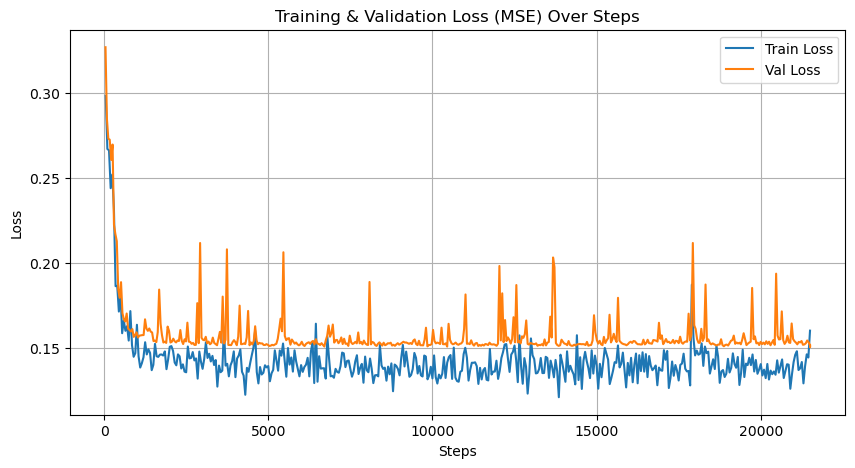

In [44]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

# Load the log directory
log_dir = r"C:\Users\20187\CSE 151B\Project\lightning_logs\version_40"
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# Get training and validation losses
train_loss = event_acc.Scalars('train/loss') if 'train/loss' in event_acc.Tags()['scalars'] else []
val_loss = event_acc.Scalars('val/loss') if 'val/loss' in event_acc.Tags()['scalars'] else []

# Plot
plt.figure(figsize=(10, 5))

if train_loss:
    plt.plot([x.step for x in train_loss], [x.value for x in train_loss], label='Train Loss')
if val_loss:
    plt.plot([x.step for x in val_loss], [x.value for x in val_loss], label='Val Loss')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training & Validation Loss (MSE) Over Steps')
plt.legend()
plt.grid(True)

plt.savefig('Training & Validation Loss (MSE) Over Steps.png')

plt.show()

Available tags:
 ['hp_metric', 'val/loss', 'val/tas/rmse', 'val/tas/time_mean_rmse', 'val/tas/time_std_mae', 'val/pr/rmse', 'val/pr/time_mean_rmse', 'val/pr/time_std_mae', 'epoch', 'train/loss', 'test/tas/rmse', 'test/tas/time_mean_rmse', 'test/tas/time_std_mae', 'test/pr/rmse', 'test/pr/time_mean_rmse', 'test/pr/time_std_mae']


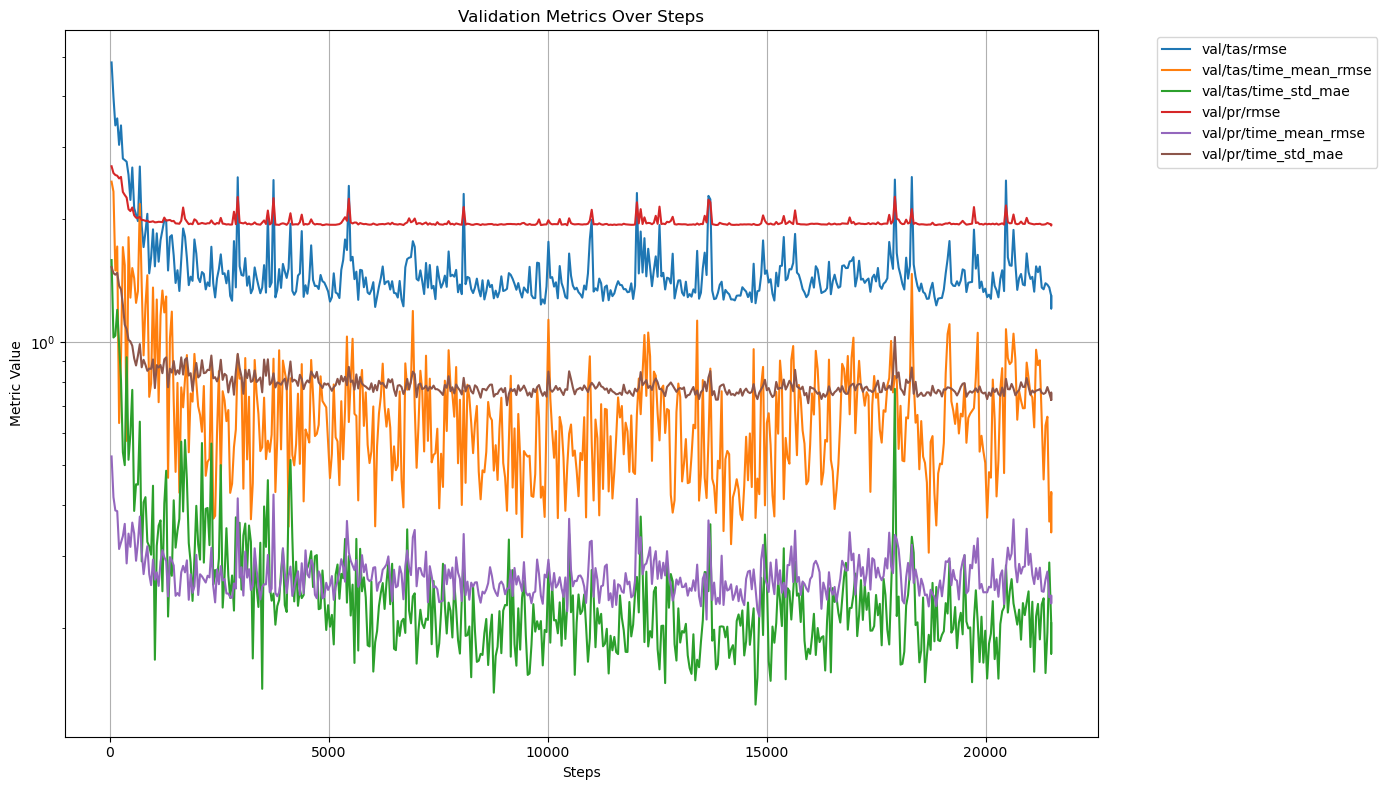

In [43]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

# Load the log directory
log_dir = r"C:\Users\20187\CSE 151B\Project\lightning_logs\version_40"
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# Check available scalar tags
tags = event_acc.Tags()['scalars']
print("Available tags:\n", tags)

# Define train and val metrics only (no test metrics)
metrics_to_plot = [
    'val/tas/rmse', 'val/tas/time_mean_rmse', 'val/tas/time_std_mae',
    'val/pr/rmse', 'val/pr/time_mean_rmse', 'val/pr/time_std_mae',
]

# Plot
plt.figure(figsize=(14, 8))

for metric in metrics_to_plot:
    if metric in tags:
        events = event_acc.Scalars(metric)
        steps = [x.step for x in events]
        values = [x.value for x in events]
        plt.plot(steps, values, label=metric)
    else:
        print(f"Warning: '{metric}' not found in logs.")

plt.xlabel('Steps')
plt.ylabel('Metric Value')
plt.yscale('log')  # Optional: helps if values vary a lot
plt.title('Validation Metrics Over Steps')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.savefig('Validation Metrics Over Steps.png')

plt.show()

NameError: name 'trues' is not defined